In [1]:
import os
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
os.chdir(r"E:\Project\Material\Training_Set\Training_Set")
os.listdir()

['RFMiD_Training_Labels.csv', 'Training']

In [5]:
# Load training CSV
train_df = pd.read_csv("RFMiD_Training_Labels.csv")
train_df["ID"] = train_df["ID"].astype(str) + ".png"
train_image_folder = "Training/"

In [6]:
# Load test CSV
test_df = pd.read_csv(r"E:\Project\Material\Test_Set\Test_Set\RFMiD_Testing_Labels.csv")
test_df["ID"] = test_df["ID"].astype(str) + ".png"
test_image_folder = r"E:\Project\Material\Test_Set\Test_Set\Test"

In [7]:
test_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1.png,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.png,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.png,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636.png,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,637.png,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,638.png,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Print the distribution of 'disease_risk'
print("Class distribution of 'disease_risk':")
print(train_df['Disease_Risk'].value_counts())

Class distribution of 'disease_risk':
Disease_Risk
1    1519
0     401
Name: count, dtype: int64


In [9]:
# Function to load and resize images
# def load_and_resize_images(image_folder, df, img_size=(512, 512)):
#      images = []
#      labels = []
#      label_columns = df.columns[1:] # Exclude 'ID' column
    
#      for img_name in tqdm(df["ID"], desc="Loading images"):
#          img_path = os.path.join(image_folder, img_name)
#          if os.path.exists(img_path):
#              img = cv2.imread(img_path)
#              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
#              img = cv2.resize(img, img_size) # Resize to 224x224
#              img = img / 255.0 # Normalize to [0,1]
#              images.append(img)
#              label_values = df[df["ID"] == img_name][label_columns].values[0]
#              labels.append(label_values)
#          else:
#              print(f"Warning: Image {img_name} not found in {image_folder}")
    
#      return np.array(images), np.array(labels)


# Batch-processing function
def load_and_resize_images(image_folder, df, img_size=(512, 512), batch_size=16):
    label_columns = df.columns[1:]
    total_images = len(df["ID"])
    
    for start_idx in range(0, total_images, batch_size):
        end_idx = min(start_idx + batch_size, total_images)
        batch_size_actual = end_idx - start_idx
        batch_images = np.empty((batch_size_actual, *img_size, 3), dtype=np.float32)
        batch_labels = np.empty((batch_size_actual, len(label_columns)), dtype=np.float32)
        
        for i, img_name in enumerate(tqdm(df["ID"][start_idx:end_idx], desc=f"Loading batch {start_idx//batch_size + 1}", leave=False)):
            img_path = os.path.join(image_folder, img_name)
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img / 255.0
                batch_images[i] = img.astype(np.float32)
                batch_labels[i] = df[df["ID"] == img_name][label_columns].values[0].astype(np.float32)
            else:
                print(f"Warning: Image {img_name} not found in {image_folder}")
                batch_images[i] = np.zeros((*img_size, 3), dtype=np.float32)
                batch_labels[i] = np.zeros(len(label_columns), dtype=np.float32)
        
        yield batch_images, batch_labels



# Process training data in batches
print("Processing training data:")
for batch_images, batch_labels in load_and_resize_images(train_image_folder, train_df, img_size=(512, 512), batch_size=32):
    print(f"Batch images shape: {batch_images.shape}, Batch labels shape: {batch_labels.shape}")
    # Here, you can use batch_images and batch_labels directly (e.g., feed to model)

# Process test data in batches
print("\nProcessing test data:")
for batch_images, batch_labels in load_and_resize_images(test_image_folder, test_df, img_size=(512, 512), batch_size=32):
    print(f"Batch images shape: {batch_images.shape}, Batch labels shape: {batch_labels.shape}")
    # Here, you can use batch_images and batch_labels directly

Processing training data:


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)

Processing test data:


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


In [10]:
# # Load validation (evaluation) data
# val_df = pd.read_csv(r'E:\Project\Material\Evaluation_Set\Evaluation_Set\RFMiD_Validation_Labels.csv')
# val_df['ID'] = val_df['ID'].astype(str) + '.png'
# val_df['Disease_Risk'] = val_df['Disease_Risk'].astype(str)


# Load evaluation (validation) data
val_image_folder=r"E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation"
val_df = pd.read_csv(r'E:\Project\Material\Evaluation_Set\Evaluation_Set\RFMiD_Validation_Labels.csv')
val_df['ID'] = val_df['ID'].astype(str) + '.png'  # Add '.png' if not present
# X_val, y_val = load_and_resize_images(r'E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation', val_df)

print("\nProcessing val data:")
for batch_images, batch_labels in load_and_resize_images(val_image_folder, val_df, img_size=(512, 512), batch_size=32):
    print(f"Batch images shape: {batch_images.shape}, Batch labels shape: {batch_labels.shape}")
    # Here, you can use batch_images and batch_labels directly

print(f"Validation images: {batch_images.shape}, Validation labels: {batch_labels.shape}")


Processing val data:


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)


Batch images shape: (32, 512, 512, 3), Batch labels shape: (32, 46)
Validation images: (32, 512, 512, 3), Validation labels: (32, 46)


In [11]:
# Custom infinite generator
def data_generator(image_folder, df, img_size=(512, 512), batch_size=16, augment=False):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else ImageDataGenerator()
    
    while True:
        # Reinitialize the generator every time it exhausts
        for batch_images, batch_labels in load_and_resize_images(image_folder, df, img_size, batch_size):
            if augment:
                batch_images = datagen.flow(batch_images, batch_size=batch_size, shuffle=False).__next__()
            yield batch_images, batch_labels

In [12]:
# Define generators
train_generator = data_generator(train_image_folder, train_df, img_size=(512, 512), batch_size=16, augment=True)
val_generator = data_generator(val_image_folder, val_df, img_size=(512, 512), batch_size=16, augment=False)
test_generator = data_generator(test_image_folder, test_df, img_size=(512, 512), batch_size=16, augment=False)



In [13]:
# Test the generator
print("Testing train_generator:")
for i, (batch_images, batch_labels) in enumerate(train_generator):
    print(f"Batch {i+1}: images shape: {batch_images.shape}, labels shape: {batch_labels.shape}")
    if i == 2:
        break

Testing train_generator:


Batch 1: images shape: (16, 512, 512, 3), labels shape: (16, 46)


Batch 2: images shape: (16, 512, 512, 3), labels shape: (16, 46)


Batch 3: images shape: (16, 512, 512, 3), labels shape: (16, 46)


In [ ]:
# Load training and test data
# X_train, y_train = load_and_resize_images(train_image_folder, train_df)
# X_test, y_test = load_and_resize_images(test_image_folder, test_df)

# print(f"Training images: {X_train.shape}, Training labels: {y_train.shape}")
# print(f"Test images: {X_test.shape}, Test labels: {y_test.shape}")



In [14]:
from sklearn.utils import compute_class_weight
# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_df['Disease_Risk'].astype(int))
# class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
# print("Computed class weights:", class_weights_dict)


# Class weights (optional, adjusted for multi-label if needed)
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_df['Disease_Risk'].astype(int))
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Computed class weights for Disease_Risk:", class_weights_dict)
# Note: For multi-label (46 outputs), this applies only to Disease_Risk. Skip or compute per label.

Computed class weights for Disease_Risk: {0: 2.3940149625935163, 1: 0.6319947333772219}


In [ ]:
# Convert 'Disease_Risk' to string for generators
# train_df['Disease_Risk'] = train_df['Disease_Risk'].astype(str)
# test_df['Disease_Risk'] = test_df['Disease_Risk'].astype(str)

In [2]:
# # # Data generators
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # train_datagen = ImageDataGenerator(
# #     rotation_range=20,
# #     width_shift_range=0.2,
# #     height_shift_range=0.2,
# #     shear_range=0.2,
# #     zoom_range=0.2,
# #     horizontal_flip=True,
# #     fill_mode='nearest'
# # )
# # val_datagen = ImageDataGenerator()
# # test_datagen = ImageDataGenerator()

# # # Create generators
# # train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
# # val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
# # test_generator = test_datagen.flow(X_test, y_test, batch_size=32)


# # Define generators using flow_from_generator
# train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# val_datagen = ImageDataGenerator()
# test_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow_from_generator(
#     lambda: load_and_resize_images(train_image_folder, train_df, img_size=(512, 512), batch_size=16),
#     target_size=(512, 512),
#     batch_size=16,
#     class_mode='raw'  # For multi-label data
# )

# val_generator = val_datagen.flow_from_generator(
#     lambda: load_and_resize_images(val_image_folder, val_df, img_size=(512, 512), batch_size=16),
#     target_size=(512, 512),
#     batch_size=16,
#     class_mode='raw'
# )

# test_generator = test_datagen.flow_from_generator(
#     lambda: load_and_resize_images(test_image_folder, test_df, img_size=(512, 512), batch_size=16),
#     target_size=(512, 512),
#     batch_size=16,
#     class_mode='raw'
# )

AttributeError: 'ImageDataGenerator' object has no attribute 'flow_from_generator'

In [15]:
# # Step 6: Define a simple CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(1, activation='sigmoid')  # Output layer for binary classification
# ])
# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Define the model (only once)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(46, activation='sigmoid')  # 46 outputs for multi-label
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 16,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_df) // 16
)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
                                                                                                                       

Epoch 1/10
  1/120 ━━━━━━━━━━━━━━━━━━━━ 12:12 6s/step - accuracy: 0.0000e+00 - loss: 0.6904

Loading batch 6:  81%|████████████████████████████████████████████████████▊            | 13/16 [00:03<00:00,  3.84it/s]

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:46 3s/step - accuracy: 0.0000e+00 - loss: 0.8548 

Loading batch 7:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.46it/s]

  3/120 ━━━━━━━━━━━━━━━━━━━━ 8:09 4s/step - accuracy: 0.0000e+00 - loss: 0.8930

Loading batch 8:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.21it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 8:17 4s/step - accuracy: 0.0625 - loss: 0.8964    

Loading batch 9:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.76it/s]

  5/120 ━━━━━━━━━━━━━━━━━━━━ 8:32 4s/step - accuracy: 0.1300 - loss: 0.8748

Loading batch 10:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.54it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 8:35 5s/step - accuracy: 0.1917 - loss: 0.8460

Loading batch 11:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.33it/s]

  7/120 ━━━━━━━━━━━━━━━━━━━━ 8:46 5s/step - accuracy: 0.2395 - loss: 0.8161

  8/120 ━━━━━━━━━━━━━━━━━━━━ 8:44 5s/step - accuracy: 0.2819 - loss: 0.7868

Loading batch 13:  75%|████████████████████████████████████████████████                | 12/16 [00:03<00:01,  3.24it/s]

  9/120 ━━━━━━━━━━━━━━━━━━━━ 8:42 5s/step - accuracy: 0.3177 - loss: 0.7599

 10/120 ━━━━━━━━━━━━━━━━━━━━ 8:46 5s/step - accuracy: 0.3497 - loss: 0.7349

 11/120 ━━━━━━━━━━━━━━━━━━━━ 8:41 5s/step - accuracy: 0.3752 - loss: 0.7117

Loading batch 16:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  3.97it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 8:36 5s/step - accuracy: 0.3956 - loss: 0.6902

 13/120 ━━━━━━━━━━━━━━━━━━━━ 8:35 5s/step - accuracy: 0.4143 - loss: 0.6700

Loading batch 18:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.71it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 8:26 5s/step - accuracy: 0.4323 - loss: 0.6512

 15/120 ━━━━━━━━━━━━━━━━━━━━ 8:22 5s/step - accuracy: 0.4493 - loss: 0.6337

 16/120 ━━━━━━━━━━━━━━━━━━━━ 8:19 5s/step - accuracy: 0.4654 - loss: 0.6176

Loading batch 21:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.54it/s]

 17/120 ━━━━━━━━━━━━━━━━━━━━ 8:13 5s/step - accuracy: 0.4806 - loss: 0.6024

Loading batch 22:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.43it/s]

 18/120 ━━━━━━━━━━━━━━━━━━━━ 8:08 5s/step - accuracy: 0.4950 - loss: 0.5884

Loading batch 23:  81%|████████████████████████████████████████████████████            | 13/16 [00:03<00:00,  4.04it/s]

 19/120 ━━━━━━━━━━━━━━━━━━━━ 8:03 5s/step - accuracy: 0.5086 - loss: 0.5754

Loading batch 24:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.94it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 8:00 5s/step - accuracy: 0.5214 - loss: 0.5633

 21/120 ━━━━━━━━━━━━━━━━━━━━ 7:57 5s/step - accuracy: 0.5336 - loss: 0.5519

Loading batch 26:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.11it/s]

 22/120 ━━━━━━━━━━━━━━━━━━━━ 7:53 5s/step - accuracy: 0.5451 - loss: 0.5411

Loading batch 27:  75%|████████████████████████████████████████████████                | 12/16 [00:03<00:01,  3.58it/s]

 23/120 ━━━━━━━━━━━━━━━━━━━━ 7:51 5s/step - accuracy: 0.5560 - loss: 0.5310

Loading batch 28:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.85it/s]

 24/120 ━━━━━━━━━━━━━━━━━━━━ 7:48 5s/step - accuracy: 0.5664 - loss: 0.5213

Loading batch 29:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.87it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 7:44 5s/step - accuracy: 0.5762 - loss: 0.5121

Loading batch 30:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.68it/s]

 26/120 ━━━━━━━━━━━━━━━━━━━━ 7:40 5s/step - accuracy: 0.5856 - loss: 0.5034

Loading batch 31:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.58it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 7:35 5s/step - accuracy: 0.5945 - loss: 0.4952

Loading batch 32:  81%|████████████████████████████████████████████████████            | 13/16 [00:03<00:00,  4.26it/s]

 28/120 ━━━━━━━━━━━━━━━━━━━━ 7:31 5s/step - accuracy: 0.6030 - loss: 0.4874

Loading batch 33:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  3.74it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 7:26 5s/step - accuracy: 0.6111 - loss: 0.4800

Loading batch 34:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  3.90it/s]

 30/120 ━━━━━━━━━━━━━━━━━━━━ 7:21 5s/step - accuracy: 0.6189 - loss: 0.4729

 31/120 ━━━━━━━━━━━━━━━━━━━━ 7:17 5s/step - accuracy: 0.6263 - loss: 0.4662

 32/120 ━━━━━━━━━━━━━━━━━━━━ 7:12 5s/step - accuracy: 0.6334 - loss: 0.4597

 33/120 ━━━━━━━━━━━━━━━━━━━━ 7:05 5s/step - accuracy: 0.6402 - loss: 0.4535

 34/120 ━━━━━━━━━━━━━━━━━━━━ 6:59 5s/step - accuracy: 0.6467 - loss: 0.4475

 35/120 ━━━━━━━━━━━━━━━━━━━━ 6:54 5s/step - accuracy: 0.6530 - loss: 0.4418

 36/120 ━━━━━━━━━━━━━━━━━━━━ 6:48 5s/step - accuracy: 0.6590 - loss: 0.4363

 37/120 ━━━━━━━━━━━━━━━━━━━━ 6:42 5s/step - accuracy: 0.6648 - loss: 0.4311

 38/120 ━━━━━━━━━━━━━━━━━━━━ 6:35 5s/step - accuracy: 0.6704 - loss: 0.4260

 39/120 ━━━━━━━━━━━━━━━━━━━━ 6:29 5s/step - accuracy: 0.6758 - loss: 0.4212

 40/120 ━━━━━━━━━━━━━━━━━━━━ 6:23 5s/step - accuracy: 0.6809 - loss: 0.4164

 41/120 ━━━━━━━━━━━━━━━━━━━━ 6:17 5s/step - accuracy: 0.6859 - loss: 0.4119

 42/120 ━━━━━━━━━━━━━━━━━━━━ 6:11 5s/step - accuracy: 0.6908 - loss: 0.4074

 43/120 ━━━━━━━━━━━━━━━━━━━━ 6:05 5s/step - accuracy: 0.6954 - loss: 0.4031

 44/120 ━━━━━━━━━━━━━━━━━━━━ 5:59 5s/step - accuracy: 0.6999 - loss: 0.3990

 45/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 5s/step - accuracy: 0.7043 - loss: 0.3949

 46/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 5s/step - accuracy: 0.7085 - loss: 0.3910

 47/120 ━━━━━━━━━━━━━━━━━━━━ 5:43 5s/step - accuracy: 0.7126 - loss: 0.3873

 48/120 ━━━━━━━━━━━━━━━━━━━━ 5:37 5s/step - accuracy: 0.7165 - loss: 0.3836

 49/120 ━━━━━━━━━━━━━━━━━━━━ 5:32 5s/step - accuracy: 0.7203 - loss: 0.3800

 50/120 ━━━━━━━━━━━━━━━━━━━━ 5:27 5s/step - accuracy: 0.7241 - loss: 0.3765

 51/120 ━━━━━━━━━━━━━━━━━━━━ 5:22 5s/step - accuracy: 0.7277 - loss: 0.3732

 52/120 ━━━━━━━━━━━━━━━━━━━━ 5:16 5s/step - accuracy: 0.7312 - loss: 0.3699

 53/120 ━━━━━━━━━━━━━━━━━━━━ 5:11 5s/step - accuracy: 0.7346 - loss: 0.3667

 54/120 ━━━━━━━━━━━━━━━━━━━━ 5:06 5s/step - accuracy: 0.7379 - loss: 0.3636

 55/120 ━━━━━━━━━━━━━━━━━━━━ 5:01 5s/step - accuracy: 0.7411 - loss: 0.3606

 56/120 ━━━━━━━━━━━━━━━━━━━━ 4:56 5s/step - accuracy: 0.7442 - loss: 0.3577

 57/120 ━━━━━━━━━━━━━━━━━━━━ 4:50 5s/step - accuracy: 0.7473 - loss: 0.3548

 58/120 ━━━━━━━━━━━━━━━━━━━━ 4:45 5s/step - accuracy: 0.7502 - loss: 0.3521

 59/120 ━━━━━━━━━━━━━━━━━━━━ 4:40 5s/step - accuracy: 0.7531 - loss: 0.3494

 60/120 ━━━━━━━━━━━━━━━━━━━━ 4:35 5s/step - accuracy: 0.7559 - loss: 0.3467

 61/120 ━━━━━━━━━━━━━━━━━━━━ 4:30 5s/step - accuracy: 0.7587 - loss: 0.3442

 62/120 ━━━━━━━━━━━━━━━━━━━━ 4:26 5s/step - accuracy: 0.7614 - loss: 0.3417

 63/120 ━━━━━━━━━━━━━━━━━━━━ 4:21 5s/step - accuracy: 0.7640 - loss: 0.3392

Loading batch 68:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.83it/s]

 64/120 ━━━━━━━━━━━━━━━━━━━━ 4:16 5s/step - accuracy: 0.7665 - loss: 0.3368

Loading batch 69:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.85it/s]

 65/120 ━━━━━━━━━━━━━━━━━━━━ 4:11 5s/step - accuracy: 0.7690 - loss: 0.3345

Loading batch 70:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.17it/s]

 66/120 ━━━━━━━━━━━━━━━━━━━━ 4:07 5s/step - accuracy: 0.7714 - loss: 0.3322

 67/120 ━━━━━━━━━━━━━━━━━━━━ 4:02 5s/step - accuracy: 0.7738 - loss: 0.3300

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:57 5s/step - accuracy: 0.7761 - loss: 0.3278

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:52 5s/step - accuracy: 0.7784 - loss: 0.3256

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:47 5s/step - accuracy: 0.7806 - loss: 0.3235

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:43 5s/step - accuracy: 0.7827 - loss: 0.3215

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:38 5s/step - accuracy: 0.7848 - loss: 0.3195

 73/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 5s/step - accuracy: 0.7869 - loss: 0.3175

 74/120 ━━━━━━━━━━━━━━━━━━━━ 3:28 5s/step - accuracy: 0.7889 - loss: 0.3156

 75/120 ━━━━━━━━━━━━━━━━━━━━ 3:23 5s/step - accuracy: 0.7909 - loss: 0.3137

 76/120 ━━━━━━━━━━━━━━━━━━━━ 3:19 5s/step - accuracy: 0.7928 - loss: 0.3118

 77/120 ━━━━━━━━━━━━━━━━━━━━ 3:14 5s/step - accuracy: 0.7947 - loss: 0.3100

 78/120 ━━━━━━━━━━━━━━━━━━━━ 3:09 5s/step - accuracy: 0.7966 - loss: 0.3082

 79/120 ━━━━━━━━━━━━━━━━━━━━ 3:05 5s/step - accuracy: 0.7984 - loss: 0.3065

 80/120 ━━━━━━━━━━━━━━━━━━━━ 3:00 5s/step - accuracy: 0.8002 - loss: 0.3047

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:55 5s/step - accuracy: 0.8020 - loss: 0.3030

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:51 5s/step - accuracy: 0.8037 - loss: 0.3014

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:46 5s/step - accuracy: 0.8054 - loss: 0.2997

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:42 5s/step - accuracy: 0.8070 - loss: 0.2981

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.8086 - loss: 0.2965

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.8102 - loss: 0.2950

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.8118 - loss: 0.2935

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - accuracy: 0.8133 - loss: 0.2920

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.8148 - loss: 0.2905

Loading batch 94:  50%|████████████████████████████████▌                                | 8/16 [00:03<00:04,  1.78it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.8163 - loss: 0.2891

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.43it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 2:10 5s/step - accuracy: 0.8178 - loss: 0.2877

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.38it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 2:06 5s/step - accuracy: 0.8192 - loss: 0.2863

Loading batch 97:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.32it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 2:03 5s/step - accuracy: 0.8206 - loss: 0.2849

Loading batch 98:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.37it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:59 5s/step - accuracy: 0.8220 - loss: 0.2836

Loading batch 99:  31%|████████████████████▎                                            | 5/16 [00:03<00:06,  1.68it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:55 5s/step - accuracy: 0.8233 - loss: 0.2822

Loading batch 100:  25%|████████████████                                                | 4/16 [00:02<00:09,  1.32it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:51 5s/step - accuracy: 0.8247 - loss: 0.2810

Loading batch 101:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.38it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:47 5s/step - accuracy: 0.8260 - loss: 0.2797

Loading batch 102:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.29it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - accuracy: 0.8273 - loss: 0.2784

Loading batch 103:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.25it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - accuracy: 0.8285 - loss: 0.2772

Loading batch 104:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.61it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - accuracy: 0.8298 - loss: 0.2760

Loading batch 105:  25%|████████████████                                                | 4/16 [00:03<00:08,  1.35it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - accuracy: 0.8310 - loss: 0.2748

Loading batch 106:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.14it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - accuracy: 0.8322 - loss: 0.2736

Loading batch 107:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.33it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - accuracy: 0.8334 - loss: 0.2724

Loading batch 108:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.39it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - accuracy: 0.8345 - loss: 0.2713

Loading batch 109:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.33it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - accuracy: 0.8357 - loss: 0.2702

Loading batch 110:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.17it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - accuracy: 0.8368 - loss: 0.2690

Loading batch 111:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.42it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - accuracy: 0.8379 - loss: 0.2679

Loading batch 112:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.36it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.8390 - loss: 0.2668 

Loading batch 113:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.22it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.8401 - loss: 0.2658

Loading batch 114:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.85it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8411 - loss: 0.2647

Loading batch 115:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.84it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.8422 - loss: 0.2637

Loading batch 116:  75%|███████████████████████████████████████████████▎               | 12/16 [00:03<00:01,  3.99it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8432 - loss: 0.2626

Loading batch 117:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.19it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.8442 - loss: 0.2616

Loading batch 118:  75%|███████████████████████████████████████████████▎               | 12/16 [00:03<00:01,  3.90it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.8452 - loss: 0.2606

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.40it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.8461 - loss: 0.2595

Loading batch 120:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.34it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8471 - loss: 0.2585

Loading batch 1:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.72it/s]

117/120 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.8480 - loss: 0.2575

Loading batch 2:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.82it/s]

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.8488 - loss: 0.2566 

Loading batch 3:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.64it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.8497 - loss: 0.2556

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8505 - loss: 0.2547

Loading batch 2:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:01<00:00, 10.35it/s]
                                                                                                                       
Loading batch 1:  12%|████████▎                                                         | 2/16 [00:00<00:02,  5.81it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.8514 - loss: 0.2538 - val_accuracy: 1.0000 - val_loss: 0.1149
Epoch 2/10



ding batch 6:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.79it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 6:55 3s/step - accuracy: 1.0000 - loss: 0.1307

ding batch 6: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.91it/s]
                                                                                                                       

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:39 3s/step - accuracy: 1.0000 - loss: 0.1241

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:43 3s/step - accuracy: 1.0000 - loss: 0.1232

  4/120 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 1.0000 - loss: 0.1232

  5/120 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - accuracy: 1.0000 - loss: 0.1226

  6/120 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - accuracy: 1.0000 - loss: 0.1220

  7/120 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 1.0000 - loss: 0.1221

  8/120 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 1.0000 - loss: 0.1225

  9/120 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - accuracy: 1.0000 - loss: 0.1232

 10/120 ━━━━━━━━━━━━━━━━━━━━ 7:27 4s/step - accuracy: 1.0000 - loss: 0.1238

 11/120 ━━━━━━━━━━━━━━━━━━━━ 7:26 4s/step - accuracy: 1.0000 - loss: 0.1242

 12/120 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - accuracy: 1.0000 - loss: 0.1244

 13/120 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - accuracy: 1.0000 - loss: 0.1243

 14/120 ━━━━━━━━━━━━━━━━━━━━ 7:16 4s/step - accuracy: 1.0000 - loss: 0.1242

 15/120 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - accuracy: 1.0000 - loss: 0.1240

 16/120 ━━━━━━━━━━━━━━━━━━━━ 7:09 4s/step - accuracy: 1.0000 - loss: 0.1239

Loading batch 21:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.44it/s]

 17/120 ━━━━━━━━━━━━━━━━━━━━ 7:05 4s/step - accuracy: 1.0000 - loss: 0.1238

 18/120 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - accuracy: 1.0000 - loss: 0.1236

Loading batch 23:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.16it/s]

 19/120 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - accuracy: 1.0000 - loss: 0.1234

Loading batch 24:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.93it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 6:57 4s/step - accuracy: 1.0000 - loss: 0.1233

Loading batch 25:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.36it/s]

 21/120 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - accuracy: 1.0000 - loss: 0.1232

Loading batch 26:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.50it/s]

 22/120 ━━━━━━━━━━━━━━━━━━━━ 6:51 4s/step - accuracy: 1.0000 - loss: 0.1230

Loading batch 27:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.87it/s]

 23/120 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 1.0000 - loss: 0.1229

Loading batch 28:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.73it/s]

 24/120 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 1.0000 - loss: 0.1227

Loading batch 29:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.72it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 6:43 4s/step - accuracy: 1.0000 - loss: 0.1226

Loading batch 30:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.63it/s]

 26/120 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - accuracy: 1.0000 - loss: 0.1224

Loading batch 31:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.65it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 1.0000 - loss: 0.1222

Loading batch 32:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.04it/s]

 28/120 ━━━━━━━━━━━━━━━━━━━━ 6:32 4s/step - accuracy: 1.0000 - loss: 0.1221

Loading batch 33:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.88it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 6:28 4s/step - accuracy: 1.0000 - loss: 0.1220

 30/120 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 1.0000 - loss: 0.1218

Loading batch 35:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.04it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 1.0000 - loss: 0.1217

Loading batch 36:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.35it/s]

 32/120 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 1.0000 - loss: 0.1215

Loading batch 37:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.04it/s]

 33/120 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 1.0000 - loss: 0.1214

Loading batch 38:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.69it/s]

 34/120 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 1.0000 - loss: 0.1213

Loading batch 39:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  4.13it/s]

 35/120 ━━━━━━━━━━━━━━━━━━━━ 6:03 4s/step - accuracy: 1.0000 - loss: 0.1211

 36/120 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 1.0000 - loss: 0.1210

Loading batch 41:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.35it/s]

 37/120 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - accuracy: 1.0000 - loss: 0.1209

 38/120 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 1.0000 - loss: 0.1208

Loading batch 43:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.23it/s]

 39/120 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - accuracy: 1.0000 - loss: 0.1207

 40/120 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 1.0000 - loss: 0.1206

Loading batch 45:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.10it/s]

 41/120 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 1.0000 - loss: 0.1204

Loading batch 46:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.84it/s]

 42/120 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 1.0000 - loss: 0.1203

Loading batch 47:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.10it/s]

 43/120 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 1.0000 - loss: 0.1202

 44/120 ━━━━━━━━━━━━━━━━━━━━ 5:26 4s/step - accuracy: 1.0000 - loss: 0.1200

Loading batch 49:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.41it/s]

 45/120 ━━━━━━━━━━━━━━━━━━━━ 5:22 4s/step - accuracy: 1.0000 - loss: 0.1199

Loading batch 50:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.21it/s]

 46/120 ━━━━━━━━━━━━━━━━━━━━ 5:18 4s/step - accuracy: 1.0000 - loss: 0.1197

Loading batch 51:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  5.38it/s]

 47/120 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 1.0000 - loss: 0.1196

 48/120 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 1.0000 - loss: 0.1195

 49/120 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 1.0000 - loss: 0.1193

 50/120 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 1.0000 - loss: 0.1192

 51/120 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 1.0000 - loss: 0.1191

 52/120 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 1.0000 - loss: 0.1189

 53/120 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 1.0000 - loss: 0.1188

 54/120 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 1.0000 - loss: 0.1187

 55/120 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 1.0000 - loss: 0.1185

 56/120 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - accuracy: 1.0000 - loss: 0.1184

 57/120 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - accuracy: 1.0000 - loss: 0.1183

 58/120 ━━━━━━━━━━━━━━━━━━━━ 4:25 4s/step - accuracy: 1.0000 - loss: 0.1182

 59/120 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 1.0000 - loss: 0.1181

 60/120 ━━━━━━━━━━━━━━━━━━━━ 4:16 4s/step - accuracy: 1.0000 - loss: 0.1180

 61/120 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 1.0000 - loss: 0.1179

 62/120 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 1.0000 - loss: 0.1178

 63/120 ━━━━━━━━━━━━━━━━━━━━ 4:03 4s/step - accuracy: 1.0000 - loss: 0.1177

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:58 4s/step - accuracy: 1.0000 - loss: 0.1175

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 1.0000 - loss: 0.1174

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 1.0000 - loss: 0.1173

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 1.0000 - loss: 0.1172

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 1.0000 - loss: 0.1171

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 1.0000 - loss: 0.1171

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 1.0000 - loss: 0.1170

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 1.0000 - loss: 0.1169

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 1.0000 - loss: 0.1168

 73/120 ━━━━━━━━━━━━━━━━━━━━ 3:20 4s/step - accuracy: 1.0000 - loss: 0.1167

 74/120 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 1.0000 - loss: 0.1166

Loading batch 79:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.26it/s]

 75/120 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 1.0000 - loss: 0.1164

 76/120 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - accuracy: 1.0000 - loss: 0.1163

Loading batch 81:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.21it/s]

 77/120 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - accuracy: 1.0000 - loss: 0.1163

Loading batch 82:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.77it/s]

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - accuracy: 1.0000 - loss: 0.1162

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 1.0000 - loss: 0.1161

Loading batch 84:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.53it/s]

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 1.0000 - loss: 0.1160

Loading batch 85:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.39it/s]

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:47 4s/step - accuracy: 1.0000 - loss: 0.1159

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - accuracy: 1.0000 - loss: 0.1158

Loading batch 87:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.87it/s]

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - accuracy: 1.0000 - loss: 0.1157

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 1.0000 - loss: 0.1156

Loading batch 89:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.03it/s]

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 1.0000 - loss: 0.1155

Loading batch 90:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.41it/s]

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - accuracy: 1.0000 - loss: 0.1154

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 1.0000 - loss: 0.1153

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 1.0000 - loss: 0.1152

Loading batch 93:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.15it/s]

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - accuracy: 1.0000 - loss: 0.1151

Loading batch 94:  50%|████████████████████████████████▌                                | 8/16 [00:03<00:04,  1.83it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 1.0000 - loss: 0.1150

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:02<00:09,  1.32it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - accuracy: 1.0000 - loss: 0.1149

Loading batch 96:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.12it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 1.0000 - loss: 0.1148

Loading batch 97:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.14it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 1.0000 - loss: 0.1147

Loading batch 98:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.11it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 1.0000 - loss: 0.1147

Loading batch 99:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.17it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 1.0000 - loss: 0.1146

Loading batch 100:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.09it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 1.0000 - loss: 0.1145

Loading batch 101:  25%|████████████████                                                | 4/16 [00:03<00:08,  1.35it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - accuracy: 1.0000 - loss: 0.1144

Loading batch 102:  19%|████████████                                                    | 3/16 [00:02<00:10,  1.18it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - accuracy: 1.0000 - loss: 0.1143

Loading batch 103:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.18it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - accuracy: 1.0000 - loss: 0.1143

Loading batch 104:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.27it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - accuracy: 1.0000 - loss: 0.1142

Loading batch 105:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.24it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - accuracy: 1.0000 - loss: 0.1141

Loading batch 106:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.17it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:24 5s/step - accuracy: 1.0000 - loss: 0.1140

Loading batch 107:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.36it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - accuracy: 1.0000 - loss: 0.1139

Loading batch 108:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.39it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - accuracy: 1.0000 - loss: 0.1139

Loading batch 109:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.12it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - accuracy: 1.0000 - loss: 0.1138

Loading batch 110:  75%|███████████████████████████████████████████████▎               | 12/16 [00:03<00:01,  3.72it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - accuracy: 1.0000 - loss: 0.1137

Loading batch 111:  75%|███████████████████████████████████████████████▎               | 12/16 [00:03<00:01,  3.91it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 1:02 5s/step - accuracy: 1.0000 - loss: 0.1136

Loading batch 112:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.07it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 1.0000 - loss: 0.1135 

Loading batch 113:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.01it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 1.0000 - loss: 0.1134

Loading batch 114:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.94it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 1.0000 - loss: 0.1133

111/120 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 1.0000 - loss: 0.1132

Loading batch 116:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.49it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9999 - loss: 0.1131

Loading batch 117:  75%|███████████████████████████████████████████████▎               | 12/16 [00:03<00:01,  3.77it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9999 - loss: 0.1130

Loading batch 118:  62%|███████████████████████████████████████▍                       | 10/16 [00:03<00:02,  2.65it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.9998 - loss: 0.1129

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:02<00:07,  1.52it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.9996 - loss: 0.1128

Loading batch 120:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.32it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.9994 - loss: 0.1127

117/120 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9992 - loss: 0.1126

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9989 - loss: 0.1125 

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9986 - loss: 0.1124

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9983 - loss: 0.1123

Loading batch 5:  81%|████████████████████████████████████████████████████▊            | 13/16 [00:01<00:00, 12.16it/s]
                                                                                                                       
Loading batch 1:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.24it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 647s 5s/step - accuracy: 0.9980 - loss: 0.1122 - val_accuracy: 1.0000 - val_loss: 0.1064
Epoch 3/10



Loading batch 1:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:02<00:00,  4.19it/s]
                                                                                                                       
ding batch 8:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  3.92it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 6:42 3s/step - accuracy: 1.0000 - loss: 0.1193

ding batch 8: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.51it/s]
                                                                                                                       

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:49 3s/step - accuracy: 1.0000 - loss: 0.1181

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:37 3s/step - accuracy: 1.0000 - loss: 0.1172

Loading batch 10:   6%|████                                                             | 1/16 [00:00<00:02,  5.13it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 6:25 3s/step - accuracy: 1.0000 - loss: 0.1168

  5/120 ━━━━━━━━━━━━━━━━━━━━ 6:21 3s/step - accuracy: 1.0000 - loss: 0.1166

Loading batch 11:  19%|████████████▏                                                    | 3/16 [00:00<00:02,  6.28it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 6:15 3s/step - accuracy: 1.0000 - loss: 0.1164

  7/120 ━━━━━━━━━━━━━━━━━━━━ 6:11 3s/step - accuracy: 1.0000 - loss: 0.1166

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:20 3s/step - accuracy: 1.0000 - loss: 0.1170

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:28 3s/step - accuracy: 1.0000 - loss: 0.1175

 10/120 ━━━━━━━━━━━━━━━━━━━━ 6:34 4s/step - accuracy: 1.0000 - loss: 0.1179

 11/120 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 1.0000 - loss: 0.1182

 12/120 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 1.0000 - loss: 0.1183

 13/120 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 1.0000 - loss: 0.1182

 14/120 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 1.0000 - loss: 0.1180

 15/120 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 1.0000 - loss: 0.1178

 16/120 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 1.0000 - loss: 0.1177

 17/120 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - accuracy: 1.0000 - loss: 0.1175

 18/120 ━━━━━━━━━━━━━━━━━━━━ 6:32 4s/step - accuracy: 1.0000 - loss: 0.1173

Loading batch 23:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.28it/s]

 19/120 ━━━━━━━━━━━━━━━━━━━━ 6:30 4s/step - accuracy: 1.0000 - loss: 0.1172

Loading batch 24:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.32it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 1.0000 - loss: 0.1171

Loading batch 25:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.59it/s]

 21/120 ━━━━━━━━━━━━━━━━━━━━ 6:27 4s/step - accuracy: 1.0000 - loss: 0.1170

Loading batch 26:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.59it/s]

 22/120 ━━━━━━━━━━━━━━━━━━━━ 6:26 4s/step - accuracy: 1.0000 - loss: 0.1168

Loading batch 27:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.62it/s]

 23/120 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 1.0000 - loss: 0.1167

Loading batch 28:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.49it/s]

 24/120 ━━━━━━━━━━━━━━━━━━━━ 6:22 4s/step - accuracy: 1.0000 - loss: 0.1166

Loading batch 29:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  5.04it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 1.0000 - loss: 0.1164

Loading batch 30:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.48it/s]

 26/120 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 1.0000 - loss: 0.1163

Loading batch 31:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.35it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 1.0000 - loss: 0.1161

 28/120 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 1.0000 - loss: 0.1160

Loading batch 33:  81%|████████████████████████████████████████████████████            | 13/16 [00:03<00:00,  4.00it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 6:09 4s/step - accuracy: 1.0000 - loss: 0.1159

Loading batch 34:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.39it/s]

 30/120 ━━━━━━━━━━━━━━━━━━━━ 6:06 4s/step - accuracy: 1.0000 - loss: 0.1159

Loading batch 35:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.32it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 6:03 4s/step - accuracy: 1.0000 - loss: 0.1157

Loading batch 36:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.36it/s]

 32/120 ━━━━━━━━━━━━━━━━━━━━ 6:00 4s/step - accuracy: 1.0000 - loss: 0.1156

Loading batch 37:  75%|████████████████████████████████████████████████                | 12/16 [00:03<00:00,  4.49it/s]

 33/120 ━━━━━━━━━━━━━━━━━━━━ 5:57 4s/step - accuracy: 1.0000 - loss: 0.1155

 34/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 1.0000 - loss: 0.1154

 35/120 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 1.0000 - loss: 0.1153

 36/120 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - accuracy: 1.0000 - loss: 0.1152

 37/120 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 1.0000 - loss: 0.1152

 38/120 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 1.0000 - loss: 0.1151

 39/120 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - accuracy: 1.0000 - loss: 0.1150

 40/120 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 1.0000 - loss: 0.1149

 41/120 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 1.0000 - loss: 0.1148

 42/120 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - accuracy: 1.0000 - loss: 0.1147

 43/120 ━━━━━━━━━━━━━━━━━━━━ 5:18 4s/step - accuracy: 1.0000 - loss: 0.1146

 44/120 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 1.0000 - loss: 0.1145

 45/120 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 1.0000 - loss: 0.1144

 46/120 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - accuracy: 1.0000 - loss: 0.1143

 47/120 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 1.0000 - loss: 0.1142

 48/120 ━━━━━━━━━━━━━━━━━━━━ 4:59 4s/step - accuracy: 1.0000 - loss: 0.1141

 49/120 ━━━━━━━━━━━━━━━━━━━━ 4:55 4s/step - accuracy: 1.0000 - loss: 0.1140

 50/120 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 1.0000 - loss: 0.1139

 51/120 ━━━━━━━━━━━━━━━━━━━━ 4:46 4s/step - accuracy: 1.0000 - loss: 0.1138

 52/120 ━━━━━━━━━━━━━━━━━━━━ 4:42 4s/step - accuracy: 1.0000 - loss: 0.1137

 53/120 ━━━━━━━━━━━━━━━━━━━━ 4:38 4s/step - accuracy: 1.0000 - loss: 0.1136

 54/120 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - accuracy: 1.0000 - loss: 0.1134

 55/120 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 1.0000 - loss: 0.1133

 56/120 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - accuracy: 1.0000 - loss: 0.1132

 57/120 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 1.0000 - loss: 0.1132

Loading batch 62:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.87it/s]

 58/120 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 1.0000 - loss: 0.1131

Loading batch 63:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.51it/s]

 59/120 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 1.0000 - loss: 0.1130

 60/120 ━━━━━━━━━━━━━━━━━━━━ 4:10 4s/step - accuracy: 1.0000 - loss: 0.1129

Loading batch 65:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.57it/s]

 61/120 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 1.0000 - loss: 0.1128

 62/120 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - accuracy: 1.0000 - loss: 0.1127

Loading batch 67:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.86it/s]

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:58 4s/step - accuracy: 1.0000 - loss: 0.1127

Loading batch 68:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.28it/s]

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 1.0000 - loss: 0.1126

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 1.0000 - loss: 0.1125

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 1.0000 - loss: 0.1124

Loading batch 71:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.31it/s]

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 1.0000 - loss: 0.1124

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 1.0000 - loss: 0.1123

Loading batch 73:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.14it/s]

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 1.0000 - loss: 0.1122

Loading batch 74:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.81it/s]

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:30 4s/step - accuracy: 0.9999 - loss: 0.1121

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - accuracy: 0.9999 - loss: 0.1120

Loading batch 76:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.05it/s]

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - accuracy: 0.9999 - loss: 0.1120

 73/120 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - accuracy: 0.9999 - loss: 0.1119

Loading batch 78:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.42it/s]

 74/120 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - accuracy: 0.9999 - loss: 0.1118

 75/120 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - accuracy: 0.9999 - loss: 0.1117

Loading batch 80:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.39it/s]

 76/120 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - accuracy: 0.9999 - loss: 0.1117

 77/120 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.9999 - loss: 0.1116

Loading batch 82:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.34it/s]

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 0.9999 - loss: 0.1115

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - accuracy: 0.9999 - loss: 0.1114

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.9999 - loss: 0.1113

Loading batch 85:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.70it/s]

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 0.9998 - loss: 0.1113

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 0.9998 - loss: 0.1112

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.9998 - loss: 0.1111

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.9998 - loss: 0.1110

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.9998 - loss: 0.1109

Loading batch 90:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.65it/s]

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - accuracy: 0.9998 - loss: 0.1109

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.9998 - loss: 0.1108

Loading batch 92:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.79it/s]

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.9998 - loss: 0.1107

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - accuracy: 0.9998 - loss: 0.1106

Loading batch 94:  44%|████████████████████████████▍                                    | 7/16 [00:02<00:05,  1.70it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.9998 - loss: 0.1106

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.40it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.9998 - loss: 0.1105

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:03<00:08,  1.34it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.9998 - loss: 0.1104

Loading batch 97:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.17it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - accuracy: 0.9998 - loss: 0.1104

Loading batch 98:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.27it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.9998 - loss: 0.1103

Loading batch 99:  31%|████████████████████▎                                            | 5/16 [00:04<00:08,  1.23it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.9998 - loss: 0.1102

Loading batch 100:  25%|████████████████                                                | 4/16 [00:03<00:10,  1.15it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 0.9998 - loss: 0.1102

Loading batch 101:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.15it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - accuracy: 0.9998 - loss: 0.1101

Loading batch 102:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.12it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - accuracy: 0.9997 - loss: 0.1101

Loading batch 103:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.44it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - accuracy: 0.9997 - loss: 0.1100

Loading batch 104:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.33it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - accuracy: 0.9997 - loss: 0.1100

Loading batch 105:  19%|████████████                                                    | 3/16 [00:03<00:16,  1.25s/it]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - accuracy: 0.9997 - loss: 0.1099

Loading batch 106:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.33it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - accuracy: 0.9997 - loss: 0.1098

Loading batch 107:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.30it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - accuracy: 0.9997 - loss: 0.1098

Loading batch 108:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.51it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - accuracy: 0.9997 - loss: 0.1097

Loading batch 109:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.35it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - accuracy: 0.9997 - loss: 0.1097

Loading batch 110:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.87it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - accuracy: 0.9997 - loss: 0.1096

Loading batch 111:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.62it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 1:01 5s/step - accuracy: 0.9997 - loss: 0.1095

108/120 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.9997 - loss: 0.1095 

Loading batch 113:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.34it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.9997 - loss: 0.1094

Loading batch 114:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.60it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9997 - loss: 0.1093

Loading batch 115:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.40it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9997 - loss: 0.1093

Loading batch 116:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.42it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.9996 - loss: 0.1092

113/120 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9995 - loss: 0.1091

Loading batch 118:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.20it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.9994 - loss: 0.1090

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:02<00:07,  1.44it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.9992 - loss: 0.1089

Loading batch 120:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.59it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9989 - loss: 0.1088

117/120 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9986 - loss: 0.1087

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9983 - loss: 0.1086 

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9980 - loss: 0.1086

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9977 - loss: 0.1085

Loading batch 3:  81%|████████████████████████████████████████████████████▊            | 13/16 [00:01<00:00, 11.46it/s]
                                                                                                                       
Loading batch 17:  88%|████████████████████████████████████████████████████████        | 14/16 [00:01<00:00, 11.61it/s]
                                                                                                                       
Loading batch 1:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.90it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 645s 5s/step - accuracy: 0.9974 - loss: 0.1084 - val_accuracy: 1.0000 - val_loss: 0.1078
Epoch 4/10



Loading batch 1:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  3.58it/s]
                                                                                                                       
Loading batch 2:   6%|████▏                                                             | 1/16 [00:00<00:02,  6.42it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 1.0000 - loss: 0.1225


ding batch 12: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.95it/s]
                                                                                                                       

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:40 3s/step - accuracy: 1.0000 - loss: 0.1165

Loading batch 13:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  4.80it/s]

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:30 3s/step - accuracy: 1.0000 - loss: 0.1138

  4/120 ━━━━━━━━━━━━━━━━━━━━ 6:21 3s/step - accuracy: 1.0000 - loss: 0.1119

Loading batch 14:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.85it/s]

  5/120 ━━━━━━━━━━━━━━━━━━━━ 6:18 3s/step - accuracy: 1.0000 - loss: 0.1107

Loading batch 15:   6%|████                                                             | 1/16 [00:00<00:02,  6.10it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 6:14 3s/step - accuracy: 1.0000 - loss: 0.1102

  7/120 ━━━━━━━━━━━━━━━━━━━━ 6:11 3s/step - accuracy: 1.0000 - loss: 0.1102

Loading batch 16:  19%|████████████▏                                                    | 3/16 [00:00<00:02,  5.78it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:06 3s/step - accuracy: 1.0000 - loss: 0.1103

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:02 3s/step - accuracy: 1.0000 - loss: 0.1105

Loading batch 17:  19%|████████████▏                                                    | 3/16 [00:00<00:02,  4.71it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 5:58 3s/step - accuracy: 1.0000 - loss: 0.1108

 11/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 3s/step - accuracy: 1.0000 - loss: 0.1109

Loading batch 18:  25%|████████████████▎                                                | 4/16 [00:00<00:02,  5.64it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 5:50 3s/step - accuracy: 1.0000 - loss: 0.1110

 13/120 ━━━━━━━━━━━━━━━━━━━━ 5:47 3s/step - accuracy: 1.0000 - loss: 0.1109

Loading batch 19:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.10it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 5:43 3s/step - accuracy: 1.0000 - loss: 0.1108

 15/120 ━━━━━━━━━━━━━━━━━━━━ 5:41 3s/step - accuracy: 1.0000 - loss: 0.1107

 16/120 ━━━━━━━━━━━━━━━━━━━━ 5:44 3s/step - accuracy: 1.0000 - loss: 0.1107

Loading batch 21:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.00it/s]

 17/120 ━━━━━━━━━━━━━━━━━━━━ 5:47 3s/step - accuracy: 1.0000 - loss: 0.1106

 18/120 ━━━━━━━━━━━━━━━━━━━━ 5:50 3s/step - accuracy: 1.0000 - loss: 0.1106

 19/120 ━━━━━━━━━━━━━━━━━━━━ 5:51 3s/step - accuracy: 1.0000 - loss: 0.1105

Loading batch 24:  81%|████████████████████████████████████████████████████            | 13/16 [00:03<00:00,  4.70it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 1.0000 - loss: 0.1106

 21/120 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 1.0000 - loss: 0.1106

 22/120 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 1.0000 - loss: 0.1106

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 1.0000 - loss: 0.1105

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:51 4s/step - accuracy: 1.0000 - loss: 0.1105

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 1.0000 - loss: 0.1105

 26/120 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - accuracy: 1.0000 - loss: 0.1104

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 1.0000 - loss: 0.1104

 28/120 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - accuracy: 1.0000 - loss: 0.1104

Loading batch 33:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.94it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - accuracy: 1.0000 - loss: 0.1104

 30/120 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - accuracy: 1.0000 - loss: 0.1103

 31/120 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 1.0000 - loss: 0.1103

 32/120 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 1.0000 - loss: 0.1102

 33/120 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 1.0000 - loss: 0.1102

 34/120 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 1.0000 - loss: 0.1101

 35/120 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 1.0000 - loss: 0.1101

 36/120 ━━━━━━━━━━━━━━━━━━━━ 5:27 4s/step - accuracy: 1.0000 - loss: 0.1100

 37/120 ━━━━━━━━━━━━━━━━━━━━ 5:23 4s/step - accuracy: 1.0000 - loss: 0.1100

 38/120 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 1.0000 - loss: 0.1100

 39/120 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 1.0000 - loss: 0.1100

 40/120 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - accuracy: 1.0000 - loss: 0.1099

 41/120 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - accuracy: 1.0000 - loss: 0.1099

 42/120 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 1.0000 - loss: 0.1098

 43/120 ━━━━━━━━━━━━━━━━━━━━ 5:04 4s/step - accuracy: 1.0000 - loss: 0.1098

 44/120 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 1.0000 - loss: 0.1097

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - accuracy: 1.0000 - loss: 0.1096

 46/120 ━━━━━━━━━━━━━━━━━━━━ 4:54 4s/step - accuracy: 1.0000 - loss: 0.1096

 47/120 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 1.0000 - loss: 0.1095

 48/120 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 1.0000 - loss: 0.1094

Loading batch 53:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.13it/s]

 49/120 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 1.0000 - loss: 0.1094

 50/120 ━━━━━━━━━━━━━━━━━━━━ 4:40 4s/step - accuracy: 1.0000 - loss: 0.1093

Loading batch 55:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.83it/s]

 51/120 ━━━━━━━━━━━━━━━━━━━━ 4:37 4s/step - accuracy: 1.0000 - loss: 0.1092

Loading batch 56:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.81it/s]

 52/120 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 1.0000 - loss: 0.1092

 53/120 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 1.0000 - loss: 0.1091

Loading batch 58:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.60it/s]

 54/120 ━━━━━━━━━━━━━━━━━━━━ 4:26 4s/step - accuracy: 1.0000 - loss: 0.1090

Loading batch 59:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.21it/s]

 55/120 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 1.0000 - loss: 0.1090

Loading batch 60:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.70it/s]

 56/120 ━━━━━━━━━━━━━━━━━━━━ 4:19 4s/step - accuracy: 1.0000 - loss: 0.1089

Loading batch 61:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.89it/s]

 57/120 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 1.0000 - loss: 0.1088

 58/120 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 1.0000 - loss: 0.1088

Loading batch 63:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.73it/s]

 59/120 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 1.0000 - loss: 0.1087

Loading batch 64:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.75it/s]

 60/120 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 1.0000 - loss: 0.1087

Loading batch 65:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.88it/s]

 61/120 ━━━━━━━━━━━━━━━━━━━━ 4:00 4s/step - accuracy: 1.0000 - loss: 0.1086

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:56 4s/step - accuracy: 1.0000 - loss: 0.1086

Loading batch 67:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.91it/s]

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - accuracy: 1.0000 - loss: 0.1085

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 1.0000 - loss: 0.1085

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:45 4s/step - accuracy: 1.0000 - loss: 0.1084

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 1.0000 - loss: 0.1084

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 1.0000 - loss: 0.1084

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 1.0000 - loss: 0.1083

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 1.0000 - loss: 0.1083

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 1.0000 - loss: 0.1082

Loading batch 75:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.92it/s]

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 1.0000 - loss: 0.1082

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - accuracy: 1.0000 - loss: 0.1081

Loading batch 77:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.55it/s]

 73/120 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - accuracy: 1.0000 - loss: 0.1081

 74/120 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 1.0000 - loss: 0.1080

Loading batch 79:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.27it/s]

 75/120 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 1.0000 - loss: 0.1080

Loading batch 80:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.22it/s]

 76/120 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - accuracy: 1.0000 - loss: 0.1079

 77/120 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 1.0000 - loss: 0.1079

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - accuracy: 1.0000 - loss: 0.1078

Loading batch 83:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.76it/s]

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 1.0000 - loss: 0.1078

Loading batch 84:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.37it/s]

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 1.0000 - loss: 0.1077

Loading batch 85:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.55it/s]

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 1.0000 - loss: 0.1077

Loading batch 86:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.52it/s]

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 1.0000 - loss: 0.1076

Loading batch 87:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.57it/s]

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:33 4s/step - accuracy: 1.0000 - loss: 0.1076

Loading batch 88:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.49it/s]

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 1.0000 - loss: 0.1075

Loading batch 89:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.62it/s]

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:25 4s/step - accuracy: 1.0000 - loss: 0.1075

Loading batch 90:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.87it/s]

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 1.0000 - loss: 0.1074

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 1.0000 - loss: 0.1073

Loading batch 92:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.95it/s]

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - accuracy: 1.0000 - loss: 0.1073

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 1.0000 - loss: 0.1072

Loading batch 94:  44%|████████████████████████████▍                                    | 7/16 [00:02<00:05,  1.60it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - accuracy: 1.0000 - loss: 0.1072

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.42it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 1.0000 - loss: 0.1071

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.30it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 1.0000 - loss: 0.1071

Loading batch 97:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.17it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 1.0000 - loss: 0.1070

Loading batch 98:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.13it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 1.0000 - loss: 0.1070

Loading batch 99:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.31it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 1.0000 - loss: 0.1070

Loading batch 100:  19%|████████████                                                    | 3/16 [00:02<00:10,  1.19it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 1.0000 - loss: 0.1069

Loading batch 101:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.10it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 1.0000 - loss: 0.1069

Loading batch 102:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.11it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 1.0000 - loss: 0.1068

Loading batch 103:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.39it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 1.0000 - loss: 0.1068

Loading batch 104:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.29it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 1.0000 - loss: 0.1068

Loading batch 105:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.28it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - accuracy: 1.0000 - loss: 0.1067

Loading batch 106:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.24it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - accuracy: 1.0000 - loss: 0.1067

Loading batch 107:  19%|████████████                                                    | 3/16 [00:02<00:10,  1.19it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - accuracy: 1.0000 - loss: 0.1067

Loading batch 108:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.62it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - accuracy: 1.0000 - loss: 0.1066

Loading batch 109:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.12it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - accuracy: 1.0000 - loss: 0.1066

Loading batch 110:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  3.95it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - accuracy: 1.0000 - loss: 0.1065

Loading batch 111:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.36it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - accuracy: 1.0000 - loss: 0.1065

Loading batch 112:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.46it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 1.0000 - loss: 0.1065 

Loading batch 113:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.08it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 1.0000 - loss: 0.1064

Loading batch 114:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.51it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 1.0000 - loss: 0.1064

Loading batch 115:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.13it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 1.0000 - loss: 0.1063

Loading batch 116:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.00it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 1.0000 - loss: 0.1062

113/120 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 1.0000 - loss: 0.1062

Loading batch 118:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.22it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.9999 - loss: 0.1061

Loading batch 119:  38%|████████████████████████                                        | 6/16 [00:03<00:06,  1.57it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.9997 - loss: 0.1060

Loading batch 120:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.34it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9994 - loss: 0.1060

Loading batch 1:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  5.14it/s]

117/120 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9991 - loss: 0.1059

Loading batch 2:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  5.10it/s]

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9987 - loss: 0.1058 

Loading batch 3:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  5.63it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9983 - loss: 0.1058

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9978 - loss: 0.1057

Loading batch 4:  81%|████████████████████████████████████████████████████▊            | 13/16 [00:01<00:00, 11.09it/s]
                                                                                                                       
Loading batch 6:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:01<00:00, 10.06it/s]
                                                                                                                       
Loading batch 1:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.12it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 643s 5s/step - accuracy: 0.9973 - loss: 0.1057 - val_accuracy: 0.3609 - val_loss: 0.1349
Epoch 5/10



ding batch 20:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.99it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 6:55 3s/step - accuracy: 0.7500 - loss: 0.1628

ding batch 20: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.21it/s]
                                                                                                                       

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:38 3s/step - accuracy: 0.8125 - loss: 0.1501

Loading batch 21:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.67it/s]

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:30 3s/step - accuracy: 0.8472 - loss: 0.1414

  4/120 ━━━━━━━━━━━━━━━━━━━━ 6:21 3s/step - accuracy: 0.8698 - loss: 0.1366

  5/120 ━━━━━━━━━━━━━━━━━━━━ 6:18 3s/step - accuracy: 0.8858 - loss: 0.1333

  6/120 ━━━━━━━━━━━━━━━━━━━━ 6:10 3s/step - accuracy: 0.8979 - loss: 0.1314

  7/120 ━━━━━━━━━━━━━━━━━━━━ 6:08 3s/step - accuracy: 0.9074 - loss: 0.1300

Loading batch 24:  25%|████████████████▎                                                | 4/16 [00:00<00:02,  5.72it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:04 3s/step - accuracy: 0.9151 - loss: 0.1289

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:01 3s/step - accuracy: 0.9214 - loss: 0.1281

Loading batch 25:  31%|████████████████████▎                                            | 5/16 [00:00<00:01,  6.28it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 5:56 3s/step - accuracy: 0.9268 - loss: 0.1273

 11/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 3s/step - accuracy: 0.9314 - loss: 0.1266

Loading batch 26:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  5.69it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 5:50 3s/step - accuracy: 0.9353 - loss: 0.1259

 13/120 ━━━━━━━━━━━━━━━━━━━━ 5:47 3s/step - accuracy: 0.9388 - loss: 0.1250

Loading batch 27:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  5.42it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 5:44 3s/step - accuracy: 0.9419 - loss: 0.1243

 15/120 ━━━━━━━━━━━━━━━━━━━━ 5:41 3s/step - accuracy: 0.9447 - loss: 0.1235

Loading batch 28:  75%|████████████████████████████████████████████████                | 12/16 [00:02<00:00,  5.05it/s]

 16/120 ━━━━━━━━━━━━━━━━━━━━ 5:38 3s/step - accuracy: 0.9472 - loss: 0.1230

 17/120 ━━━━━━━━━━━━━━━━━━━━ 5:34 3s/step - accuracy: 0.9494 - loss: 0.1224

Loading batch 29:  88%|████████████████████████████████████████████████████████        | 14/16 [00:02<00:00,  4.63it/s]

 18/120 ━━━━━━━━━━━━━━━━━━━━ 5:30 3s/step - accuracy: 0.9515 - loss: 0.1219

 19/120 ━━━━━━━━━━━━━━━━━━━━ 5:26 3s/step - accuracy: 0.9533 - loss: 0.1214

 20/120 ━━━━━━━━━━━━━━━━━━━━ 5:23 3s/step - accuracy: 0.9550 - loss: 0.1210

Loading batch 31:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

 21/120 ━━━━━━━━━━━━━━━━━━━━ 5:19 3s/step - accuracy: 0.9566 - loss: 0.1207

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:13 3s/step - accuracy: 0.9594 - loss: 0.1200

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:10 3s/step - accuracy: 0.9607 - loss: 0.1197

Loading batch 33:   6%|████                                                             | 1/16 [00:00<00:02,  6.62it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:07 3s/step - accuracy: 0.9618 - loss: 0.1194

 26/120 ━━━━━━━━━━━━━━━━━━━━ 5:04 3s/step - accuracy: 0.9629 - loss: 0.1191

Loading batch 34:   6%|████                                                             | 1/16 [00:00<00:02,  5.87it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:00 3s/step - accuracy: 0.9640 - loss: 0.1188

 28/120 ━━━━━━━━━━━━━━━━━━━━ 4:57 3s/step - accuracy: 0.9649 - loss: 0.1185

Loading batch 35:  38%|████████████████████████▍                                        | 6/16 [00:01<00:01,  5.78it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 4:54 3s/step - accuracy: 0.9658 - loss: 0.1183

 30/120 ━━━━━━━━━━━━━━━━━━━━ 4:51 3s/step - accuracy: 0.9667 - loss: 0.1181

Loading batch 36:  56%|████████████████████████████████████▌                            | 9/16 [00:01<00:01,  6.46it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 4:48 3s/step - accuracy: 0.9675 - loss: 0.1178

 32/120 ━━━━━━━━━━━━━━━━━━━━ 4:45 3s/step - accuracy: 0.9683 - loss: 0.1176

 33/120 ━━━━━━━━━━━━━━━━━━━━ 4:42 3s/step - accuracy: 0.9690 - loss: 0.1174

 34/120 ━━━━━━━━━━━━━━━━━━━━ 4:41 3s/step - accuracy: 0.9697 - loss: 0.1172

 35/120 ━━━━━━━━━━━━━━━━━━━━ 4:40 3s/step - accuracy: 0.9704 - loss: 0.1170

 36/120 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - accuracy: 0.9710 - loss: 0.1168

 37/120 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - accuracy: 0.9716 - loss: 0.1166

 38/120 ━━━━━━━━━━━━━━━━━━━━ 4:36 3s/step - accuracy: 0.9722 - loss: 0.1165

 39/120 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.9727 - loss: 0.1163

 40/120 ━━━━━━━━━━━━━━━━━━━━ 4:33 3s/step - accuracy: 0.9733 - loss: 0.1162

 41/120 ━━━━━━━━━━━━━━━━━━━━ 4:31 3s/step - accuracy: 0.9738 - loss: 0.1160

 42/120 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - accuracy: 0.9742 - loss: 0.1158

 43/120 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.9747 - loss: 0.1156

 44/120 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - accuracy: 0.9752 - loss: 0.1155

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:22 3s/step - accuracy: 0.9756 - loss: 0.1153

 46/120 ━━━━━━━━━━━━━━━━━━━━ 4:19 4s/step - accuracy: 0.9760 - loss: 0.1151

 47/120 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - accuracy: 0.9764 - loss: 0.1150

 48/120 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 0.9768 - loss: 0.1148

 49/120 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - accuracy: 0.9771 - loss: 0.1147

 50/120 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.9775 - loss: 0.1145

 51/120 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 0.9778 - loss: 0.1144

 52/120 ━━━━━━━━━━━━━━━━━━━━ 4:04 4s/step - accuracy: 0.9782 - loss: 0.1142

 53/120 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - accuracy: 0.9785 - loss: 0.1141

 54/120 ━━━━━━━━━━━━━━━━━━━━ 3:58 4s/step - accuracy: 0.9788 - loss: 0.1139

 55/120 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 0.9791 - loss: 0.1138

 56/120 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - accuracy: 0.9794 - loss: 0.1137

Loading batch 61:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.23it/s]

 57/120 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.9797 - loss: 0.1135

Loading batch 62:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.99it/s]

 58/120 ━━━━━━━━━━━━━━━━━━━━ 3:47 4s/step - accuracy: 0.9800 - loss: 0.1134

Loading batch 63:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.05it/s]

 59/120 ━━━━━━━━━━━━━━━━━━━━ 3:44 4s/step - accuracy: 0.9802 - loss: 0.1133

Loading batch 64:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.15it/s]

 60/120 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - accuracy: 0.9805 - loss: 0.1132

Loading batch 65:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.76it/s]

 61/120 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - accuracy: 0.9808 - loss: 0.1131

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - accuracy: 0.9810 - loss: 0.1130

Loading batch 67:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.15it/s]

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.9812 - loss: 0.1129

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 0.9815 - loss: 0.1128

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.9817 - loss: 0.1126

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - accuracy: 0.9819 - loss: 0.1126

Loading batch 71:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.32it/s]

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 0.9821 - loss: 0.1125

Loading batch 72:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.11it/s]

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.9823 - loss: 0.1124

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.9825 - loss: 0.1123

Loading batch 74:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.29it/s]

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:09 4s/step - accuracy: 0.9827 - loss: 0.1122

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:06 4s/step - accuracy: 0.9829 - loss: 0.1121

Loading batch 76:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.20it/s]

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.9831 - loss: 0.1120

 73/120 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - accuracy: 0.9833 - loss: 0.1119

Loading batch 78:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.16it/s]

 74/120 ━━━━━━━━━━━━━━━━━━━━ 2:55 4s/step - accuracy: 0.9835 - loss: 0.1118

 75/120 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - accuracy: 0.9837 - loss: 0.1117

 76/120 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.9838 - loss: 0.1116

 77/120 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 0.9840 - loss: 0.1115

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 0.9842 - loss: 0.1114

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:37 4s/step - accuracy: 0.9843 - loss: 0.1113

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 0.9845 - loss: 0.1112

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.9846 - loss: 0.1112

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.9848 - loss: 0.1111

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.9849 - loss: 0.1110

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.9851 - loss: 0.1109

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - accuracy: 0.9852 - loss: 0.1108

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - accuracy: 0.9854 - loss: 0.1107

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.9855 - loss: 0.1106

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.9856 - loss: 0.1105

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.9858 - loss: 0.1104

Loading batch 94:  44%|████████████████████████████▍                                    | 7/16 [00:02<00:05,  1.79it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - accuracy: 0.9859 - loss: 0.1104

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.47it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.9860 - loss: 0.1103

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.27it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.9861 - loss: 0.1102

Loading batch 97:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.32it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 0.9862 - loss: 0.1101

Loading batch 98:  31%|████████████████████▎                                            | 5/16 [00:03<00:06,  1.59it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.9864 - loss: 0.1101

Loading batch 99:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.37it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.9865 - loss: 0.1100

Loading batch 100:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.57it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.9866 - loss: 0.1099

Loading batch 101:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.27it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.9867 - loss: 0.1099

Loading batch 102:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.41it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.9868 - loss: 0.1098

Loading batch 103:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.62it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.9869 - loss: 0.1097

Loading batch 104:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.38it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.9870 - loss: 0.1097

Loading batch 105:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.36it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.9871 - loss: 0.1096

Loading batch 106:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.47it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - accuracy: 0.9872 - loss: 0.1095

Loading batch 107:  25%|████████████████                                                | 4/16 [00:02<00:07,  1.50it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - accuracy: 0.9873 - loss: 0.1095

Loading batch 108:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.57it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:09 4s/step - accuracy: 0.9874 - loss: 0.1094

Loading batch 109:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.32it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.9875 - loss: 0.1094

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - accuracy: 0.9876 - loss: 0.1093

Loading batch 111:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  3.67it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9877 - loss: 0.1092 

108/120 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.9878 - loss: 0.1092

Loading batch 113:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.20it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9879 - loss: 0.1091

Loading batch 114:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.46it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9880 - loss: 0.1090

Loading batch 115:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.95it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9881 - loss: 0.1089

Loading batch 116:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.22it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9882 - loss: 0.1089

Loading batch 117:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.17it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9883 - loss: 0.1088

Loading batch 118:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.05it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9883 - loss: 0.1087

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:02<00:07,  1.43it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9884 - loss: 0.1086

Loading batch 120:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.28it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9884 - loss: 0.1085

Loading batch 1:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  5.16it/s]

117/120 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.9884 - loss: 0.1084

118/120 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9883 - loss: 0.1084 

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9881 - loss: 0.1083

Loading batch 4:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.38it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9879 - loss: 0.1082

Loading batch 8:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:01<00:00, 10.13it/s]
                                                                                                                       
Loading batch 35:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  8.63it/s]
                                                                                                                       
Loading batch 1:  19%|████████████▍                                                     | 3/16 [00:00<00:02,  6.35it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 619s 5s/step - accuracy: 0.9877 - loss: 0.1082 - val_accuracy: 0.0000e+00 - val_loss: 0.1373
Epoch 6/10



Loading batch 2:  25%|████████████████▌                                                 | 4/16 [00:00<00:02,  5.79it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 6:57 4s/step - accuracy: 0.0625 - loss: 0.1656

Loading batch 2:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.17it/s]
                                                                                                                       
ding batch 31:  25%|████████████████▎                                                | 4/16 [00:00<00:01,  6.27it/s]

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:32 3s/step - accuracy: 0.1719 - loss: 0.1560


ding batch 31: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.58it/s]
                                                                                                                    

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:28 3s/step - accuracy: 0.2812 - loss: 0.1470

Loading batch 32:  19%|████████████▏                                                    | 3/16 [00:00<00:02,  5.55it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 6:19 3s/step - accuracy: 0.3672 - loss: 0.1425

  5/120 ━━━━━━━━━━━━━━━━━━━━ 6:15 3s/step - accuracy: 0.4338 - loss: 0.1392

Loading batch 33:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  7.16it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 6:10 3s/step - accuracy: 0.4865 - loss: 0.1373

  7/120 ━━━━━━━━━━━━━━━━━━━━ 6:08 3s/step - accuracy: 0.5292 - loss: 0.1358

Loading batch 34:  38%|████████████████████████▍                                        | 6/16 [00:01<00:01,  5.37it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:04 3s/step - accuracy: 0.5646 - loss: 0.1347

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:00 3s/step - accuracy: 0.5945 - loss: 0.1337

Loading batch 35:  56%|████████████████████████████████████▌                            | 9/16 [00:01<00:01,  5.76it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 5:58 3s/step - accuracy: 0.6200 - loss: 0.1329

 11/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 3s/step - accuracy: 0.6422 - loss: 0.1321

Loading batch 36:  75%|████████████████████████████████████████████████                | 12/16 [00:02<00:00,  6.52it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 5:52 3s/step - accuracy: 0.6616 - loss: 0.1312

 13/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 3s/step - accuracy: 0.6787 - loss: 0.1301

Loading batch 37:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  5.00it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 5:45 3s/step - accuracy: 0.6940 - loss: 0.1292

 15/120 ━━━━━━━━━━━━━━━━━━━━ 5:41 3s/step - accuracy: 0.7078 - loss: 0.1283

 17/120 ━━━━━━━━━━━━━━━━━━━━ 5:36 3s/step - accuracy: 0.7314 - loss: 0.1269

 18/120 ━━━━━━━━━━━━━━━━━━━━ 5:34 3s/step - accuracy: 0.7417 - loss: 0.1263

Loading batch 40:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

 19/120 ━━━━━━━━━━━━━━━━━━━━ 5:31 3s/step - accuracy: 0.7512 - loss: 0.1258

 20/120 ━━━━━━━━━━━━━━━━━━━━ 5:27 3s/step - accuracy: 0.7599 - loss: 0.1253

Loading batch 41:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.56it/s]

 21/120 ━━━━━━━━━━━━━━━━━━━━ 5:23 3s/step - accuracy: 0.7679 - loss: 0.1249

 22/120 ━━━━━━━━━━━━━━━━━━━━ 5:20 3s/step - accuracy: 0.7753 - loss: 0.1245

Loading batch 42:  25%|████████████████▎                                                | 4/16 [00:00<00:02,  5.87it/s]

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:16 3s/step - accuracy: 0.7823 - loss: 0.1241

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:13 3s/step - accuracy: 0.7887 - loss: 0.1237

Loading batch 43:  31%|████████████████████▎                                            | 5/16 [00:00<00:01,  6.29it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:09 3s/step - accuracy: 0.7948 - loss: 0.1234

 26/120 ━━━━━━━━━━━━━━━━━━━━ 5:06 3s/step - accuracy: 0.8005 - loss: 0.1230

Loading batch 44:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  5.71it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:02 3s/step - accuracy: 0.8058 - loss: 0.1227

 28/120 ━━━━━━━━━━━━━━━━━━━━ 4:59 3s/step - accuracy: 0.8108 - loss: 0.1224

Loading batch 45:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  5.07it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 4:56 3s/step - accuracy: 0.8156 - loss: 0.1221

 30/120 ━━━━━━━━━━━━━━━━━━━━ 4:53 3s/step - accuracy: 0.8200 - loss: 0.1218

Loading batch 46:  56%|████████████████████████████████████▌                            | 9/16 [00:01<00:01,  5.30it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 4:49 3s/step - accuracy: 0.8243 - loss: 0.1216

 32/120 ━━━━━━━━━━━━━━━━━━━━ 4:46 3s/step - accuracy: 0.8283 - loss: 0.1213

Loading batch 47:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:00,  5.71it/s]

 33/120 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - accuracy: 0.8321 - loss: 0.1211

 34/120 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - accuracy: 0.8358 - loss: 0.1208

Loading batch 48:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:00,  5.56it/s]

 35/120 ━━━━━━━━━━━━━━━━━━━━ 4:36 3s/step - accuracy: 0.8392 - loss: 0.1206

 36/120 ━━━━━━━━━━━━━━━━━━━━ 4:32 3s/step - accuracy: 0.8426 - loss: 0.1203

Loading batch 49:  88%|████████████████████████████████████████████████████████        | 14/16 [00:02<00:00,  5.84it/s]

 37/120 ━━━━━━━━━━━━━━━━━━━━ 4:29 3s/step - accuracy: 0.8457 - loss: 0.1201

 38/120 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.8487 - loss: 0.1200

 39/120 ━━━━━━━━━━━━━━━━━━━━ 4:23 3s/step - accuracy: 0.8516 - loss: 0.1198

Loading batch 51:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

 40/120 ━━━━━━━━━━━━━━━━━━━━ 4:20 3s/step - accuracy: 0.8544 - loss: 0.1196

 41/120 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.8571 - loss: 0.1194

Loading batch 52:  38%|████████████████████████▍                                        | 6/16 [00:01<00:01,  5.84it/s]

 42/120 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - accuracy: 0.8596 - loss: 0.1192

 43/120 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.8621 - loss: 0.1189

Loading batch 53:  38%|████████████████████████▍                                        | 6/16 [00:01<00:01,  5.36it/s]

 44/120 ━━━━━━━━━━━━━━━━━━━━ 4:07 3s/step - accuracy: 0.8644 - loss: 0.1187

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:03 3s/step - accuracy: 0.8667 - loss: 0.1185

Loading batch 54:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  5.66it/s]

 46/120 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - accuracy: 0.8689 - loss: 0.1183

 47/120 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - accuracy: 0.8710 - loss: 0.1181

Loading batch 55:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  6.41it/s]

 48/120 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - accuracy: 0.8730 - loss: 0.1179

 49/120 ━━━━━━━━━━━━━━━━━━━━ 3:50 3s/step - accuracy: 0.8750 - loss: 0.1177

Loading batch 56:  56%|████████████████████████████████████▌                            | 9/16 [00:01<00:01,  6.08it/s]

 50/120 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - accuracy: 0.8769 - loss: 0.1176

 51/120 ━━━━━━━━━━━━━━━━━━━━ 3:44 3s/step - accuracy: 0.8787 - loss: 0.1174

Loading batch 57:  75%|████████████████████████████████████████████████                | 12/16 [00:02<00:00,  6.60it/s]

 52/120 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - accuracy: 0.8805 - loss: 0.1172

 53/120 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - accuracy: 0.8822 - loss: 0.1170

 54/120 ━━━━━━━━━━━━━━━━━━━━ 3:34 3s/step - accuracy: 0.8839 - loss: 0.1168

 55/120 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - accuracy: 0.8855 - loss: 0.1167

 56/120 ━━━━━━━━━━━━━━━━━━━━ 3:30 3s/step - accuracy: 0.8871 - loss: 0.1165

 57/120 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - accuracy: 0.8886 - loss: 0.1164

 58/120 ━━━━━━━━━━━━━━━━━━━━ 3:25 3s/step - accuracy: 0.8901 - loss: 0.1162

 59/120 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - accuracy: 0.8915 - loss: 0.1160

 60/120 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - accuracy: 0.8929 - loss: 0.1159

 61/120 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - accuracy: 0.8943 - loss: 0.1158

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - accuracy: 0.8956 - loss: 0.1156

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - accuracy: 0.8968 - loss: 0.1155

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.8981 - loss: 0.1154

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:07 3s/step - accuracy: 0.8993 - loss: 0.1152

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - accuracy: 0.9005 - loss: 0.1151

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - accuracy: 0.9016 - loss: 0.1150

Loading batch 72:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.10it/s]

 68/120 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - accuracy: 0.9028 - loss: 0.1149

Loading batch 73:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.64it/s]

 69/120 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - accuracy: 0.9039 - loss: 0.1148

Loading batch 74:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.88it/s]

 70/120 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - accuracy: 0.9049 - loss: 0.1146

 71/120 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - accuracy: 0.9060 - loss: 0.1145

 72/120 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.9070 - loss: 0.1144

 73/120 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 0.9080 - loss: 0.1143

Loading batch 78:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.36it/s]

 74/120 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - accuracy: 0.9089 - loss: 0.1142

Loading batch 79:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.11it/s]

 75/120 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - accuracy: 0.9099 - loss: 0.1140

 76/120 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.9108 - loss: 0.1139

Loading batch 81:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.17it/s]

 77/120 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.9117 - loss: 0.1138

Loading batch 82:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.47it/s]

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 0.9126 - loss: 0.1137

Loading batch 83:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.19it/s]

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.9134 - loss: 0.1136

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:23 4s/step - accuracy: 0.9143 - loss: 0.1135

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.9151 - loss: 0.1134

Loading batch 86:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.42it/s]

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.9159 - loss: 0.1133

Loading batch 87:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.14it/s]

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - accuracy: 0.9167 - loss: 0.1132

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - accuracy: 0.9175 - loss: 0.1130

Loading batch 89:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.57it/s]

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.9182 - loss: 0.1129

Loading batch 90:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.35it/s]

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.9190 - loss: 0.1128

Loading batch 91:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.07it/s]

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.9197 - loss: 0.1127

Loading batch 92:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.27it/s]

 88/120 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - accuracy: 0.9204 - loss: 0.1126

 89/120 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.9211 - loss: 0.1125

Loading batch 94:  44%|████████████████████████████▍                                    | 7/16 [00:02<00:05,  1.74it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.9218 - loss: 0.1124

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:03<00:08,  1.34it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 0.9224 - loss: 0.1123

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.30it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.9231 - loss: 0.1122

Loading batch 97:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.11it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - accuracy: 0.9237 - loss: 0.1121

Loading batch 98:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.13it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.9244 - loss: 0.1120

Loading batch 99:  19%|████████████▏                                                    | 3/16 [00:02<00:11,  1.12it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step - accuracy: 0.9250 - loss: 0.1119

Loading batch 100:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.25it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.9256 - loss: 0.1118

Loading batch 101:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.23it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.9262 - loss: 0.1118

Loading batch 102:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.29it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.9268 - loss: 0.1117

Loading batch 103:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.30it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.9274 - loss: 0.1116

Loading batch 104:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.32it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - accuracy: 0.9280 - loss: 0.1115

Loading batch 105:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.13it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - accuracy: 0.9285 - loss: 0.1114

Loading batch 106:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.43it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - accuracy: 0.9291 - loss: 0.1113

Loading batch 107:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.13it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - accuracy: 0.9296 - loss: 0.1112

Loading batch 108:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.52it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.9301 - loss: 0.1112

Loading batch 109:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.29it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - accuracy: 0.9307 - loss: 0.1111

Loading batch 110:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.19it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9312 - loss: 0.1110 

Loading batch 111:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.02it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.9317 - loss: 0.1109

Loading batch 112:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.38it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9322 - loss: 0.1108

Loading batch 113:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.30it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9327 - loss: 0.1107

Loading batch 114:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  3.98it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9332 - loss: 0.1106

Loading batch 115:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.12it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9336 - loss: 0.1106

Loading batch 116:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.09it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9341 - loss: 0.1105

Loading batch 117:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.40it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9346 - loss: 0.1104

Loading batch 118:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  4.15it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.9350 - loss: 0.1103

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:02<00:07,  1.42it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9355 - loss: 0.1102

Loading batch 120:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.29it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9359 - loss: 0.1101

117/120 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9363 - loss: 0.1100

Loading batch 2:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.71it/s]

118/120 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9367 - loss: 0.1099 

Loading batch 3:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.82it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9371 - loss: 0.1098

Loading batch 4:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  5.11it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9375 - loss: 0.1097

Loading batch 20:  81%|████████████████████████████████████████████████████            | 13/16 [00:01<00:00, 10.56it/s]
                                                                                                                       
Loading batch 24:  81%|████████████████████████████████████████████████████            | 13/16 [00:01<00:00, 12.46it/s]
                                                                                                                       
ding batch 19:   0%|                                                                         | 0/16 [00:00<?, ?it/s]
                                                                                                                       
ding batch 29:  69%|████████████████████████████████████████████                    | 11/16 [00:01<00:00,  8.47it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 602s 5s/step - accuracy: 0.9379 - loss: 0.1096 - val_accuracy: 0.9062 - val_loss: 0.1296
Epoch 7/10


Loading batch 2:   6%|████▏                                                             | 1/16 [00:00<00:02,  5.89it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 6:47 3s/step - accuracy: 0.9375 - loss: 0.1548

Loading batch 2:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:02<00:00,  3.94it/s]
                                                                                                                       
ding batch 30:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:02,  3.76it/s]

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:47 3s/step - accuracy: 0.9375 - loss: 0.1459


ding batch 30: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.68it/s]
                                                                                                                    

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:30 3s/step - accuracy: 0.9375 - loss: 0.1381

Loading batch 31:  56%|████████████████████████████████████▌                            | 9/16 [00:01<00:01,  4.90it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 6:23 3s/step - accuracy: 0.9375 - loss: 0.1345

  5/120 ━━━━━━━━━━━━━━━━━━━━ 6:16 3s/step - accuracy: 0.9400 - loss: 0.1316

Loading batch 32:  62%|████████████████████████████████████████                        | 10/16 [00:01<00:01,  5.07it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 6:13 3s/step - accuracy: 0.9431 - loss: 0.1299

  7/120 ━━━━━━━━━━━━━━━━━━━━ 6:09 3s/step - accuracy: 0.9461 - loss: 0.1287

Loading batch 33:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.76it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:05 3s/step - accuracy: 0.9489 - loss: 0.1280

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:01 3s/step - accuracy: 0.9515 - loss: 0.1274

Loading batch 34:  69%|████████████████████████████████████████████                    | 11/16 [00:01<00:00,  5.47it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 5:57 3s/step - accuracy: 0.9539 - loss: 0.1268

 11/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 3s/step - accuracy: 0.9560 - loss: 0.1263

Loading batch 35:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  5.43it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 5:52 3s/step - accuracy: 0.9579 - loss: 0.1256

 13/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 3s/step - accuracy: 0.9597 - loss: 0.1248

Loading batch 36:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:02<00:00,  5.67it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 5:45 3s/step - accuracy: 0.9613 - loss: 0.1241

 15/120 ━━━━━━━━━━━━━━━━━━━━ 5:41 3s/step - accuracy: 0.9628 - loss: 0.1233

Loading batch 37:  88%|████████████████████████████████████████████████████████        | 14/16 [00:02<00:00,  4.95it/s]

 16/120 ━━━━━━━━━━━━━━━━━━━━ 5:38 3s/step - accuracy: 0.9641 - loss: 0.1228

 17/120 ━━━━━━━━━━━━━━━━━━━━ 5:34 3s/step - accuracy: 0.9653 - loss: 0.1222

Loading batch 38:  88%|████████████████████████████████████████████████████████        | 14/16 [00:02<00:00,  4.64it/s]

 18/120 ━━━━━━━━━━━━━━━━━━━━ 5:31 3s/step - accuracy: 0.9665 - loss: 0.1217

 19/120 ━━━━━━━━━━━━━━━━━━━━ 5:27 3s/step - accuracy: 0.9676 - loss: 0.1213

Loading batch 39:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  4.71it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 5:24 3s/step - accuracy: 0.9686 - loss: 0.1210

 21/120 ━━━━━━━━━━━━━━━━━━━━ 5:20 3s/step - accuracy: 0.9695 - loss: 0.1206

Loading batch 40:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:01,  4.61it/s]

 22/120 ━━━━━━━━━━━━━━━━━━━━ 5:17 3s/step - accuracy: 0.9704 - loss: 0.1203

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:13 3s/step - accuracy: 0.9712 - loss: 0.1200

Loading batch 41:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  5.01it/s]

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:10 3s/step - accuracy: 0.9720 - loss: 0.1197

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:07 3s/step - accuracy: 0.9727 - loss: 0.1194

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:00 3s/step - accuracy: 0.9740 - loss: 0.1188

 28/120 ━━━━━━━━━━━━━━━━━━━━ 4:57 3s/step - accuracy: 0.9746 - loss: 0.1185

Loading batch 44:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.68it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 4:54 3s/step - accuracy: 0.9752 - loss: 0.1183

 30/120 ━━━━━━━━━━━━━━━━━━━━ 4:51 3s/step - accuracy: 0.9757 - loss: 0.1181

Loading batch 45:   6%|████                                                             | 1/16 [00:00<00:02,  5.94it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 4:48 3s/step - accuracy: 0.9763 - loss: 0.1179

 32/120 ━━━━━━━━━━━━━━━━━━━━ 4:45 3s/step - accuracy: 0.9768 - loss: 0.1176

Loading batch 46:  12%|████████▏                                                        | 2/16 [00:00<00:02,  4.91it/s]

 33/120 ━━━━━━━━━━━━━━━━━━━━ 4:41 3s/step - accuracy: 0.9772 - loss: 0.1174

 34/120 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - accuracy: 0.9777 - loss: 0.1172

Loading batch 47:   6%|████                                                             | 1/16 [00:00<00:02,  5.13it/s]

 35/120 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.9781 - loss: 0.1170

 36/120 ━━━━━━━━━━━━━━━━━━━━ 4:31 3s/step - accuracy: 0.9785 - loss: 0.1168

Loading batch 48:  12%|████████▏                                                        | 2/16 [00:00<00:02,  4.98it/s]

 37/120 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - accuracy: 0.9789 - loss: 0.1166

 38/120 ━━━━━━━━━━━━━━━━━━━━ 4:25 3s/step - accuracy: 0.9793 - loss: 0.1165

Loading batch 49:  25%|████████████████▎                                                | 4/16 [00:00<00:02,  5.57it/s]

 39/120 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - accuracy: 0.9797 - loss: 0.1163

 40/120 ━━━━━━━━━━━━━━━━━━━━ 4:18 3s/step - accuracy: 0.9800 - loss: 0.1161

Loading batch 50:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  6.20it/s]

 41/120 ━━━━━━━━━━━━━━━━━━━━ 4:15 3s/step - accuracy: 0.9804 - loss: 0.1160

 42/120 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.9807 - loss: 0.1158

Loading batch 51:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  5.37it/s]

 43/120 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.9810 - loss: 0.1156

 44/120 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - accuracy: 0.9813 - loss: 0.1154

Loading batch 52:  62%|████████████████████████████████████████                        | 10/16 [00:01<00:01,  5.83it/s]

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - accuracy: 0.9816 - loss: 0.1152

 46/120 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - accuracy: 0.9819 - loss: 0.1150

Loading batch 53:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.97it/s]

 47/120 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - accuracy: 0.9822 - loss: 0.1149

 48/120 ━━━━━━━━━━━━━━━━━━━━ 3:52 3s/step - accuracy: 0.9824 - loss: 0.1147

Loading batch 54:  75%|████████████████████████████████████████████████                | 12/16 [00:02<00:00,  5.19it/s]

 49/120 ━━━━━━━━━━━━━━━━━━━━ 3:49 3s/step - accuracy: 0.9827 - loss: 0.1145

 50/120 ━━━━━━━━━━━━━━━━━━━━ 3:46 3s/step - accuracy: 0.9829 - loss: 0.1144

 51/120 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - accuracy: 0.9832 - loss: 0.1142

 52/120 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - accuracy: 0.9834 - loss: 0.1140

 53/120 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - accuracy: 0.9836 - loss: 0.1139

Loading batch 58:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.97it/s]

 54/120 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - accuracy: 0.9838 - loss: 0.1137

Loading batch 59:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.70it/s]

 55/120 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - accuracy: 0.9840 - loss: 0.1136

Loading batch 60:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.41it/s]

 56/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - accuracy: 0.9842 - loss: 0.1134

Loading batch 61:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.08it/s]

 57/120 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - accuracy: 0.9844 - loss: 0.1133

 58/120 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - accuracy: 0.9846 - loss: 0.1132

Loading batch 63:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.95it/s]

 59/120 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - accuracy: 0.9848 - loss: 0.1130

 60/120 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - accuracy: 0.9849 - loss: 0.1129

Loading batch 65:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.48it/s]

 61/120 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - accuracy: 0.9851 - loss: 0.1128

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - accuracy: 0.9853 - loss: 0.1127

Loading batch 67:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.83it/s]

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - accuracy: 0.9854 - loss: 0.1126

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - accuracy: 0.9856 - loss: 0.1124

Loading batch 69: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  6.01it/s]

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - accuracy: 0.9857 - loss: 0.1123

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - accuracy: 0.9859 - loss: 0.1122

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:05 4s/step - accuracy: 0.9860 - loss: 0.1121

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - accuracy: 0.9861 - loss: 0.1120

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.9863 - loss: 0.1119

 70/120 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 0.9864 - loss: 0.1118

 71/120 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - accuracy: 0.9865 - loss: 0.1117

Loading batch 76:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.83it/s]

 72/120 ━━━━━━━━━━━━━━━━━━━━ 2:51 4s/step - accuracy: 0.9867 - loss: 0.1116

Loading batch 77:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.08it/s]

 73/120 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.9868 - loss: 0.1115

 74/120 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.9869 - loss: 0.1114

Loading batch 79:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.07it/s]

 75/120 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 0.9870 - loss: 0.1113

 76/120 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - accuracy: 0.9871 - loss: 0.1112

 77/120 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.9872 - loss: 0.1111

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.9873 - loss: 0.1110

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 0.9874 - loss: 0.1109

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.9874 - loss: 0.1108

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.9875 - loss: 0.1107

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.9875 - loss: 0.1106

Loading batch 87:  75%|████████████████████████████████████████████████                | 12/16 [00:03<00:01,  3.04it/s]

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.9876 - loss: 0.1105

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.9876 - loss: 0.1104

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 0.9877 - loss: 0.1103

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step - accuracy: 0.9877 - loss: 0.1102

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.9878 - loss: 0.1101

 88/120 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.9878 - loss: 0.1100

 89/120 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.9879 - loss: 0.1099

Loading batch 94:  50%|████████████████████████████████▌                                | 8/16 [00:02<00:04,  1.85it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.9879 - loss: 0.1098

Loading batch 95:  31%|████████████████████▎                                            | 5/16 [00:02<00:06,  1.68it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.9880 - loss: 0.1097

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:02<00:07,  1.52it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.9880 - loss: 0.1096

Loading batch 97:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.27it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - accuracy: 0.9881 - loss: 0.1096

Loading batch 98:  31%|████████████████████▎                                            | 5/16 [00:03<00:06,  1.62it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.9881 - loss: 0.1095

Loading batch 99:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.46it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:37 4s/step - accuracy: 0.9882 - loss: 0.1094

Loading batch 100:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.30it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:34 4s/step - accuracy: 0.9882 - loss: 0.1093

Loading batch 101:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.56it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.9883 - loss: 0.1093

Loading batch 102:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.30it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.9883 - loss: 0.1092

Loading batch 103:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.58it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.9884 - loss: 0.1091

Loading batch 104:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.35it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - accuracy: 0.9884 - loss: 0.1090

Loading batch 105:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.38it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - accuracy: 0.9885 - loss: 0.1090

Loading batch 106:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.56it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - accuracy: 0.9885 - loss: 0.1089

Loading batch 107:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.61it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - accuracy: 0.9886 - loss: 0.1088

Loading batch 108:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.53it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - accuracy: 0.9886 - loss: 0.1087

Loading batch 109:  25%|████████████████                                                | 4/16 [00:02<00:09,  1.33it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - accuracy: 0.9887 - loss: 0.1087

Loading batch 110:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.69it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9887 - loss: 0.1086 

Loading batch 111:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.61it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.9887 - loss: 0.1085

Loading batch 112:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.81it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9888 - loss: 0.1085

Loading batch 113:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.48it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9888 - loss: 0.1084

Loading batch 114:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.37it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9889 - loss: 0.1083

Loading batch 115:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.38it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9889 - loss: 0.1082

Loading batch 116:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.71it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9890 - loss: 0.1081

Loading batch 117:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.92it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9890 - loss: 0.1081

Loading batch 118:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.35it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.9891 - loss: 0.1080

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:02<00:07,  1.46it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9891 - loss: 0.1079

Loading batch 120:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.28it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9891 - loss: 0.1078

117/120 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.9892 - loss: 0.1077

118/120 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9892 - loss: 0.1076 

Loading batch 3:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  5.04it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9892 - loss: 0.1075

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9891 - loss: 0.1075

Loading batch 4:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:01<00:00, 11.00it/s]
                                                                                                                       
ding batch 30:  62%|████████████████████████████████████████                        | 10/16 [00:01<00:00,  7.01it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 603s 5s/step - accuracy: 0.9891 - loss: 0.1074 - val_accuracy: 0.8313 - val_loss: 0.1279
Epoch 8/10


Loading batch 2:   6%|████▏                                                             | 1/16 [00:00<00:03,  4.71it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 6:53 3s/step - accuracy: 0.9375 - loss: 0.1422

Loading batch 2:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:02<00:00,  5.32it/s]
                                                                                                                       
ding batch 31:  50%|████████████████████████████████▌                                | 8/16 [00:02<00:01,  4.15it/s]

  2/120 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.9375 - loss: 0.1364


ding batch 31: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.15it/s]
                                                                                                                    

  3/120 ━━━━━━━━━━━━━━━━━━━━ 6:36 3s/step - accuracy: 0.9306 - loss: 0.1300

Loading batch 32:  56%|████████████████████████████████████▌                            | 9/16 [00:02<00:01,  4.38it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 6:26 3s/step - accuracy: 0.9323 - loss: 0.1272

  5/120 ━━━━━━━━━━━━━━━━━━━━ 6:19 3s/step - accuracy: 0.9358 - loss: 0.1249

Loading batch 33:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  5.08it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 6:12 3s/step - accuracy: 0.9396 - loss: 0.1236

  7/120 ━━━━━━━━━━━━━━━━━━━━ 6:08 3s/step - accuracy: 0.9431 - loss: 0.1227

Loading batch 34:  38%|████████████████████████▍                                        | 6/16 [00:01<00:02,  4.81it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:04 3s/step - accuracy: 0.9463 - loss: 0.1221

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:00 3s/step - accuracy: 0.9492 - loss: 0.1218

Loading batch 35:  38%|████████████████████████▍                                        | 6/16 [00:01<00:02,  4.92it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 5:56 3s/step - accuracy: 0.9518 - loss: 0.1215

 11/120 ━━━━━━━━━━━━━━━━━━━━ 5:53 3s/step - accuracy: 0.9541 - loss: 0.1212

Loading batch 36:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.47it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 3s/step - accuracy: 0.9562 - loss: 0.1208

 13/120 ━━━━━━━━━━━━━━━━━━━━ 5:45 3s/step - accuracy: 0.9581 - loss: 0.1203

Loading batch 37:   6%|████                                                             | 1/16 [00:00<00:01,  7.97it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 5:43 3s/step - accuracy: 0.9598 - loss: 0.1197

 15/120 ━━━━━━━━━━━━━━━━━━━━ 5:40 3s/step - accuracy: 0.9614 - loss: 0.1191

Loading batch 38:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.81it/s]

 16/120 ━━━━━━━━━━━━━━━━━━━━ 5:36 3s/step - accuracy: 0.9628 - loss: 0.1187

 17/120 ━━━━━━━━━━━━━━━━━━━━ 5:34 3s/step - accuracy: 0.9641 - loss: 0.1183

Loading batch 39:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.14it/s]

 18/120 ━━━━━━━━━━━━━━━━━━━━ 5:29 3s/step - accuracy: 0.9653 - loss: 0.1179

 19/120 ━━━━━━━━━━━━━━━━━━━━ 5:27 3s/step - accuracy: 0.9665 - loss: 0.1176

Loading batch 40:  25%|████████████████▎                                                | 4/16 [00:00<00:02,  5.34it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 5:23 3s/step - accuracy: 0.9675 - loss: 0.1174

 21/120 ━━━━━━━━━━━━━━━━━━━━ 5:20 3s/step - accuracy: 0.9685 - loss: 0.1171

Loading batch 41:  31%|████████████████████▎                                            | 5/16 [00:01<00:02,  5.20it/s]

 22/120 ━━━━━━━━━━━━━━━━━━━━ 5:16 3s/step - accuracy: 0.9694 - loss: 0.1169

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:13 3s/step - accuracy: 0.9703 - loss: 0.1167

Loading batch 42:  31%|████████████████████▎                                            | 5/16 [00:01<00:02,  4.94it/s]

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:10 3s/step - accuracy: 0.9711 - loss: 0.1165

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:06 3s/step - accuracy: 0.9718 - loss: 0.1163

Loading batch 43:  38%|████████████████████████▍                                        | 6/16 [00:01<00:01,  5.79it/s]

 26/120 ━━━━━━━━━━━━━━━━━━━━ 5:03 3s/step - accuracy: 0.9726 - loss: 0.1160

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:00 3s/step - accuracy: 0.9732 - loss: 0.1158

Loading batch 44:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  5.87it/s]

 28/120 ━━━━━━━━━━━━━━━━━━━━ 4:57 3s/step - accuracy: 0.9739 - loss: 0.1156

 29/120 ━━━━━━━━━━━━━━━━━━━━ 4:54 3s/step - accuracy: 0.9745 - loss: 0.1154

Loading batch 45:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  5.15it/s]

 30/120 ━━━━━━━━━━━━━━━━━━━━ 4:50 3s/step - accuracy: 0.9750 - loss: 0.1153

 31/120 ━━━━━━━━━━━━━━━━━━━━ 4:47 3s/step - accuracy: 0.9756 - loss: 0.1151

Loading batch 46:  38%|████████████████████████▍                                        | 6/16 [00:01<00:01,  5.92it/s]

 32/120 ━━━━━━━━━━━━━━━━━━━━ 4:44 3s/step - accuracy: 0.9761 - loss: 0.1150

 33/120 ━━━━━━━━━━━━━━━━━━━━ 4:41 3s/step - accuracy: 0.9766 - loss: 0.1148

Loading batch 47:  38%|████████████████████████▍                                        | 6/16 [00:01<00:04,  2.40it/s]

 34/120 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - accuracy: 0.9771 - loss: 0.1146

 35/120 ━━━━━━━━━━━━━━━━━━━━ 4:35 3s/step - accuracy: 0.9775 - loss: 0.1145

Loading batch 48:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  5.65it/s]

 36/120 ━━━━━━━━━━━━━━━━━━━━ 4:32 3s/step - accuracy: 0.9780 - loss: 0.1143

 37/120 ━━━━━━━━━━━━━━━━━━━━ 4:29 3s/step - accuracy: 0.9784 - loss: 0.1142

Loading batch 49:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:00,  6.21it/s]

 38/120 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.9788 - loss: 0.1141

 39/120 ━━━━━━━━━━━━━━━━━━━━ 4:22 3s/step - accuracy: 0.9791 - loss: 0.1140

Loading batch 50:  81%|████████████████████████████████████████████████████            | 13/16 [00:02<00:00,  6.05it/s]

 40/120 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - accuracy: 0.9795 - loss: 0.1138

 41/120 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.9799 - loss: 0.1137

Loading batch 51:  75%|████████████████████████████████████████████████                | 12/16 [00:02<00:00,  5.28it/s]

 42/120 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - accuracy: 0.9802 - loss: 0.1135

 43/120 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.9805 - loss: 0.1134

 44/120 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - accuracy: 0.9808 - loss: 0.1133

Loading batch 53:   6%|████                                                             | 1/16 [00:00<00:02,  7.46it/s]

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:03 3s/step - accuracy: 0.9811 - loss: 0.1131

 46/120 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - accuracy: 0.9814 - loss: 0.1130

Loading batch 54:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.97it/s]

 47/120 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - accuracy: 0.9817 - loss: 0.1128

 48/120 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - accuracy: 0.9820 - loss: 0.1127

Loading batch 55:  31%|████████████████████▎                                            | 5/16 [00:00<00:01,  6.97it/s]

 49/120 ━━━━━━━━━━━━━━━━━━━━ 3:50 3s/step - accuracy: 0.9822 - loss: 0.1126

 50/120 ━━━━━━━━━━━━━━━━━━━━ 3:46 3s/step - accuracy: 0.9825 - loss: 0.1124

Loading batch 56:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  6.29it/s]

 51/120 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - accuracy: 0.9828 - loss: 0.1123

 52/120 ━━━━━━━━━━━━━━━━━━━━ 3:40 3s/step - accuracy: 0.9830 - loss: 0.1122

 53/120 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - accuracy: 0.9832 - loss: 0.1120

 54/120 ━━━━━━━━━━━━━━━━━━━━ 3:35 3s/step - accuracy: 0.9834 - loss: 0.1119

 55/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - accuracy: 0.9837 - loss: 0.1118

 56/120 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - accuracy: 0.9839 - loss: 0.1117

 57/120 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - accuracy: 0.9841 - loss: 0.1115

 58/120 ━━━━━━━━━━━━━━━━━━━━ 3:26 3s/step - accuracy: 0.9843 - loss: 0.1114

 59/120 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - accuracy: 0.9845 - loss: 0.1113

 60/120 ━━━━━━━━━━━━━━━━━━━━ 3:21 3s/step - accuracy: 0.9847 - loss: 0.1112

 61/120 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - accuracy: 0.9849 - loss: 0.1111

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - accuracy: 0.9850 - loss: 0.1110

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - accuracy: 0.9852 - loss: 0.1109

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.9854 - loss: 0.1108

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - accuracy: 0.9855 - loss: 0.1107

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - accuracy: 0.9857 - loss: 0.1106

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - accuracy: 0.9859 - loss: 0.1105

 68/120 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - accuracy: 0.9860 - loss: 0.1105

 69/120 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - accuracy: 0.9862 - loss: 0.1104

 70/120 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - accuracy: 0.9863 - loss: 0.1103

 71/120 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - accuracy: 0.9865 - loss: 0.1102

 72/120 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.9866 - loss: 0.1101

 73/120 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.9867 - loss: 0.1100

 74/120 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 0.9869 - loss: 0.1099

 75/120 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - accuracy: 0.9870 - loss: 0.1099

 76/120 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.9871 - loss: 0.1098

 77/120 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.9872 - loss: 0.1097

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 0.9874 - loss: 0.1096

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.9875 - loss: 0.1095

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.9876 - loss: 0.1094

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.9877 - loss: 0.1093

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.9878 - loss: 0.1093

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.9879 - loss: 0.1092

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - accuracy: 0.9881 - loss: 0.1091

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.9882 - loss: 0.1090

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.9883 - loss: 0.1089

 87/120 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - accuracy: 0.9884 - loss: 0.1088

 88/120 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.9885 - loss: 0.1088

 89/120 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.9886 - loss: 0.1087

Loading batch 94:  50%|████████████████████████████████▌                                | 8/16 [00:03<00:04,  1.74it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 1:49 4s/step - accuracy: 0.9887 - loss: 0.1086

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:02<00:08,  1.44it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.9888 - loss: 0.1085

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:02<00:07,  1.53it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 1:43 4s/step - accuracy: 0.9888 - loss: 0.1085

Loading batch 97:  31%|████████████████████▎                                            | 5/16 [00:03<00:06,  1.59it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.9889 - loss: 0.1084

Loading batch 98:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.29it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.9890 - loss: 0.1083

Loading batch 99:  25%|████████████████▎                                                | 4/16 [00:03<00:08,  1.34it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - accuracy: 0.9891 - loss: 0.1082

Loading batch 100:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.25it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - accuracy: 0.9892 - loss: 0.1082

Loading batch 101:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.28it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.9893 - loss: 0.1081

Loading batch 102:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.39it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:26 4s/step - accuracy: 0.9894 - loss: 0.1080

Loading batch 103:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.15it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.9895 - loss: 0.1080

Loading batch 104:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.14it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:20 4s/step - accuracy: 0.9895 - loss: 0.1079

Loading batch 105:  19%|████████████                                                    | 3/16 [00:02<00:11,  1.09it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.9896 - loss: 0.1078

Loading batch 106:  31%|████████████████████                                            | 5/16 [00:04<00:10,  1.05it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - accuracy: 0.9897 - loss: 0.1078

Loading batch 107:  31%|████████████████████                                            | 5/16 [00:04<00:10,  1.09it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - accuracy: 0.9898 - loss: 0.1077

Loading batch 108:  25%|████████████████                                                | 4/16 [00:03<00:10,  1.18it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.9898 - loss: 0.1076

Loading batch 109:  25%|████████████████                                                | 4/16 [00:04<00:11,  1.04it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - accuracy: 0.9899 - loss: 0.1076

Loading batch 110:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:04<00:00,  3.33it/s]

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.9900 - loss: 0.1075

Loading batch 111:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:04<00:00,  3.71it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.9901 - loss: 0.1074 

Loading batch 112:  75%|███████████████████████████████████████████████▎               | 12/16 [00:03<00:01,  3.77it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9901 - loss: 0.1074

109/120 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9902 - loss: 0.1073

Loading batch 114:  44%|████████████████████████████                                    | 7/16 [00:05<00:10,  1.12s/it]

110/120 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9903 - loss: 0.1072

Loading batch 115:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:04<00:00,  3.85it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9903 - loss: 0.1072

112/120 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9904 - loss: 0.1071

Loading batch 117:  62%|███████████████████████████████████████▍                       | 10/16 [00:04<00:02,  2.49it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.9905 - loss: 0.1070

Loading batch 118:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:04<00:00,  3.86it/s]

114/120 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.9905 - loss: 0.1069

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:03<00:09,  1.21it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9906 - loss: 0.1068

Loading batch 120:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.38it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9907 - loss: 0.1068

117/120 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.9907 - loss: 0.1067

Loading batch 2:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.01it/s]

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9908 - loss: 0.1066 

Loading batch 3:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.03it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9908 - loss: 0.1065

Loading batch 4:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.42it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9909 - loss: 0.1064

Loading batch 5:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:01<00:00, 10.22it/s]
                                                                                                                       
Loading batch 29:  88%|████████████████████████████████████████████████████████        | 14/16 [00:01<00:00, 10.70it/s]
                                                                                                                       
Loading batch 1:  19%|████████████▍                                                     | 3/16 [00:00<00:02,  5.82it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 640s 5s/step - accuracy: 0.9910 - loss: 0.1064 - val_accuracy: 0.9969 - val_loss: 0.1224
Epoch 9/10


Loading batch 1:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  3.64it/s]
                                                                                                                       
Loading batch 2:  25%|████████████████▌                                                 | 4/16 [00:00<00:02,  5.38it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 8:38 4s/step - accuracy: 1.0000 - loss: 0.1431

Loading batch 31:  25%|████████████████▎                                                | 4/16 [00:00<00:02,  4.70it/s]

  2/120 ━━━━━━━━━━━━━━━━━━━━ 7:47 4s/step - accuracy: 1.0000 - loss: 0.1364

  3/120 ━━━━━━━━━━━━━━━━━━━━ 7:28 4s/step - accuracy: 1.0000 - loss: 0.1298

Loading batch 32:  31%|████████████████████▎                                            | 5/16 [00:01<00:02,  5.12it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - accuracy: 0.9961 - loss: 0.1265

  5/120 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 0.9944 - loss: 0.1240

Loading batch 33:  19%|████████████▏                                                    | 3/16 [00:00<00:02,  5.07it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 0.9936 - loss: 0.1225

  7/120 ━━━━━━━━━━━━━━━━━━━━ 7:02 4s/step - accuracy: 0.9932 - loss: 0.1214

Loading batch 34:   6%|████                                                             | 1/16 [00:00<00:02,  6.88it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:55 4s/step - accuracy: 0.9931 - loss: 0.1206

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:51 4s/step - accuracy: 0.9931 - loss: 0.1202

Loading batch 35:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 0.9932 - loss: 0.1198

Loading batch 35:  81%|████████████████████████████████████████████████████            | 13/16 [00:03<00:00,  3.56it/s]

 11/120 ━━━━━━━━━━━━━━━━━━━━ 6:46 4s/step - accuracy: 0.9933 - loss: 0.1194

 12/120 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.9934 - loss: 0.1190

Loading batch 36:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.11it/s]

 13/120 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 0.9935 - loss: 0.1184

 14/120 ━━━━━━━━━━━━━━━━━━━━ 6:32 4s/step - accuracy: 0.9937 - loss: 0.1178

Loading batch 37:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:01,  4.33it/s]

 15/120 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 0.9938 - loss: 0.1172

 16/120 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 0.9940 - loss: 0.1168

Loading batch 38:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  5.10it/s]

 17/120 ━━━━━━━━━━━━━━━━━━━━ 6:20 4s/step - accuracy: 0.9941 - loss: 0.1164

 18/120 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 0.9942 - loss: 0.1160

Loading batch 39:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.75it/s]

 19/120 ━━━━━━━━━━━━━━━━━━━━ 6:14 4s/step - accuracy: 0.9944 - loss: 0.1157

 20/120 ━━━━━━━━━━━━━━━━━━━━ 6:09 4s/step - accuracy: 0.9945 - loss: 0.1155

Loading batch 40:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.21it/s]

 21/120 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - accuracy: 0.9946 - loss: 0.1153

 22/120 ━━━━━━━━━━━━━━━━━━━━ 6:02 4s/step - accuracy: 0.9947 - loss: 0.1151

Loading batch 41:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.14it/s]

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - accuracy: 0.9948 - loss: 0.1149

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 0.9949 - loss: 0.1147

Loading batch 42:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:00,  5.29it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:51 4s/step - accuracy: 0.9950 - loss: 0.1145

 26/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.9951 - loss: 0.1143

Loading batch 43:  69%|████████████████████████████████████████████                    | 11/16 [00:02<00:01,  4.28it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - accuracy: 0.9952 - loss: 0.1141

 28/120 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - accuracy: 0.9953 - loss: 0.1139

Loading batch 44:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.28it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - accuracy: 0.9954 - loss: 0.1138

 30/120 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.9955 - loss: 0.1136

Loading batch 45:  56%|████████████████████████████████████▌                            | 9/16 [00:02<00:01,  4.57it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.9956 - loss: 0.1135

 32/120 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 0.9957 - loss: 0.1133

Loading batch 46:  50%|████████████████████████████████▌                                | 8/16 [00:02<00:01,  4.16it/s]

 33/120 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - accuracy: 0.9957 - loss: 0.1132

 34/120 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 0.9958 - loss: 0.1130

Loading batch 47:  38%|████████████████████████▍                                        | 6/16 [00:01<00:02,  4.57it/s]

 35/120 ━━━━━━━━━━━━━━━━━━━━ 5:13 4s/step - accuracy: 0.9959 - loss: 0.1129

 36/120 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.9959 - loss: 0.1127

Loading batch 48:  56%|████████████████████████████████████▌                            | 9/16 [00:01<00:01,  5.21it/s]

 37/120 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - accuracy: 0.9960 - loss: 0.1126

 38/120 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - accuracy: 0.9961 - loss: 0.1125

Loading batch 49:  56%|████████████████████████████████████▌                            | 9/16 [00:02<00:01,  4.64it/s]

 39/120 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - accuracy: 0.9961 - loss: 0.1124

 40/120 ━━━━━━━━━━━━━━━━━━━━ 4:55 4s/step - accuracy: 0.9962 - loss: 0.1123

Loading batch 50:  50%|████████████████████████████████▌                                | 8/16 [00:02<00:01,  4.03it/s]

 41/120 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.9962 - loss: 0.1121

 42/120 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 0.9963 - loss: 0.1120

Loading batch 51:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.57it/s]

 43/120 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 0.9963 - loss: 0.1119

 44/120 ━━━━━━━━━━━━━━━━━━━━ 4:40 4s/step - accuracy: 0.9964 - loss: 0.1117

Loading batch 52:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.55it/s]

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.9964 - loss: 0.1116

 46/120 ━━━━━━━━━━━━━━━━━━━━ 4:32 4s/step - accuracy: 0.9965 - loss: 0.1115

Loading batch 53:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  5.20it/s]

 47/120 ━━━━━━━━━━━━━━━━━━━━ 4:29 4s/step - accuracy: 0.9965 - loss: 0.1113

 48/120 ━━━━━━━━━━━━━━━━━━━━ 4:25 4s/step - accuracy: 0.9966 - loss: 0.1112

Loading batch 54:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.98it/s]

 49/120 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 0.9966 - loss: 0.1111

 50/120 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.9967 - loss: 0.1109

 51/120 ━━━━━━━━━━━━━━━━━━━━ 4:15 4s/step - accuracy: 0.9967 - loss: 0.1108

Loading batch 56:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.54it/s]

 52/120 ━━━━━━━━━━━━━━━━━━━━ 4:13 4s/step - accuracy: 0.9967 - loss: 0.1107

 53/120 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 0.9968 - loss: 0.1106

 54/120 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.9968 - loss: 0.1104

Loading batch 59:  56%|████████████████████████████████████▌                            | 9/16 [00:03<00:05,  1.28it/s]

 55/120 ━━━━━━━━━━━━━━━━━━━━ 4:07 4s/step - accuracy: 0.9969 - loss: 0.1103

 56/120 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 0.9969 - loss: 0.1102

 57/120 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - accuracy: 0.9969 - loss: 0.1101

 58/120 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 0.9970 - loss: 0.1100

 59/120 ━━━━━━━━━━━━━━━━━━━━ 3:56 4s/step - accuracy: 0.9970 - loss: 0.1099

 60/120 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - accuracy: 0.9970 - loss: 0.1098

 61/120 ━━━━━━━━━━━━━━━━━━━━ 3:50 4s/step - accuracy: 0.9971 - loss: 0.1097

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:47 4s/step - accuracy: 0.9971 - loss: 0.1096

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:44 4s/step - accuracy: 0.9971 - loss: 0.1095

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:40 4s/step - accuracy: 0.9972 - loss: 0.1094

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:37 4s/step - accuracy: 0.9972 - loss: 0.1093

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:34 4s/step - accuracy: 0.9972 - loss: 0.1093

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - accuracy: 0.9972 - loss: 0.1092

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - accuracy: 0.9973 - loss: 0.1091

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:24 4s/step - accuracy: 0.9973 - loss: 0.1090

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.9973 - loss: 0.1089

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:18 4s/step - accuracy: 0.9973 - loss: 0.1088

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.9974 - loss: 0.1088

 73/120 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - accuracy: 0.9974 - loss: 0.1087

 74/120 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - accuracy: 0.9974 - loss: 0.1086

 75/120 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 0.9974 - loss: 0.1085

 76/120 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.9975 - loss: 0.1084

 77/120 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 0.9975 - loss: 0.1084

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - accuracy: 0.9975 - loss: 0.1083

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.9975 - loss: 0.1082

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:45 4s/step - accuracy: 0.9976 - loss: 0.1081

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:41 4s/step - accuracy: 0.9976 - loss: 0.1080

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:38 4s/step - accuracy: 0.9976 - loss: 0.1080

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:34 4s/step - accuracy: 0.9976 - loss: 0.1079

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.9976 - loss: 0.1078

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.9977 - loss: 0.1077

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.9977 - loss: 0.1076

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:18 4s/step - accuracy: 0.9977 - loss: 0.1076

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.9977 - loss: 0.1075

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:10 4s/step - accuracy: 0.9977 - loss: 0.1074

Loading batch 94:  50%|████████████████████████████████▌                                | 8/16 [00:03<00:05,  1.52it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.9977 - loss: 0.1073

Loading batch 95:  31%|████████████████████▎                                            | 5/16 [00:03<00:07,  1.44it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.9978 - loss: 0.1073

Loading batch 96:  31%|████████████████████▎                                            | 5/16 [00:03<00:07,  1.39it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.9978 - loss: 0.1072

Loading batch 97:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.22it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:56 4s/step - accuracy: 0.9978 - loss: 0.1071

Loading batch 98:  31%|████████████████████▎                                            | 5/16 [00:03<00:07,  1.49it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:53 4s/step - accuracy: 0.9978 - loss: 0.1071

Loading batch 99:  25%|████████████████▎                                                | 4/16 [00:03<00:10,  1.19it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.9978 - loss: 0.1070

Loading batch 100:  25%|████████████████                                                | 4/16 [00:03<00:10,  1.19it/s]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.9978 - loss: 0.1070

Loading batch 101:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.20it/s]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - accuracy: 0.9979 - loss: 0.1069

Loading batch 102:  31%|████████████████████                                            | 5/16 [00:03<00:08,  1.36it/s]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - accuracy: 0.9979 - loss: 0.1068

Loading batch 103:  31%|████████████████████                                            | 5/16 [00:03<00:08,  1.31it/s]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - accuracy: 0.9979 - loss: 0.1068

Loading batch 104:  31%|████████████████████                                            | 5/16 [00:03<00:07,  1.42it/s]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - accuracy: 0.9979 - loss: 0.1067

Loading batch 105:  31%|████████████████████                                            | 5/16 [00:03<00:08,  1.37it/s]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - accuracy: 0.9979 - loss: 0.1066

Loading batch 106:  25%|████████████████                                                | 4/16 [00:03<00:12,  1.02s/it]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:24 5s/step - accuracy: 0.9979 - loss: 0.1066

Loading batch 107:  25%|████████████████                                                | 4/16 [00:03<00:10,  1.14it/s]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - accuracy: 0.9979 - loss: 0.1065

Loading batch 108:  38%|████████████████████████                                        | 6/16 [00:03<00:06,  1.56it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - accuracy: 0.9980 - loss: 0.1065

Loading batch 109:  31%|████████████████████                                            | 5/16 [00:03<00:06,  1.58it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - accuracy: 0.9980 - loss: 0.1064

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - accuracy: 0.9980 - loss: 0.1063

Loading batch 111:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.16it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 1:01 5s/step - accuracy: 0.9980 - loss: 0.1063

Loading batch 112:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:03<00:00,  4.14it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.9980 - loss: 0.1062 

Loading batch 113:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.23it/s]

109/120 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.9980 - loss: 0.1061

Loading batch 114:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  3.94it/s]

110/120 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9980 - loss: 0.1061

Loading batch 115:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  3.71it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9981 - loss: 0.1060

Loading batch 116:  69%|███████████████████████████████████████████▎                   | 11/16 [00:03<00:01,  2.81it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9981 - loss: 0.1059

Loading batch 117:  81%|███████████████████████████████████████████████████▏           | 13/16 [00:03<00:00,  3.56it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9981 - loss: 0.1059

114/120 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.9981 - loss: 0.1058

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:03<00:08,  1.22it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.9981 - loss: 0.1057

Loading batch 120:  19%|████████████                                                    | 3/16 [00:03<00:13,  1.08s/it]

116/120 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.9981 - loss: 0.1056

117/120 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9981 - loss: 0.1055

Loading batch 2:  75%|████████████████████████████████████████████████▊                | 12/16 [00:03<00:01,  3.34it/s]

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9981 - loss: 0.1055 

Loading batch 3:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  3.74it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9981 - loss: 0.1054

Loading batch 4:  94%|████████████████████████████████████████████████████████████▉    | 15/16 [00:03<00:00,  4.34it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9981 - loss: 0.1053

Loading batch 33:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:05<00:00,  2.91it/s]
                                                                                                                       
ding batch 29:  88%|████████████████████████████████████████████████████████        | 14/16 [00:01<00:00,  6.35it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 672s 6s/step - accuracy: 0.9981 - loss: 0.1052 - val_accuracy: 0.9844 - val_loss: 0.1213
Epoch 10/10


Loading batch 2:  25%|████████████████▌                                                 | 4/16 [00:00<00:02,  4.89it/s]

  1/120 ━━━━━━━━━━━━━━━━━━━━ 7:53 4s/step - accuracy: 1.0000 - loss: 0.1352

Loading batch 2:  88%|████████████████████████████████████████████████████████▉        | 14/16 [00:03<00:00,  4.19it/s]
                                                                                                                       
ding batch 30:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  3.92it/s]

  2/120 ━━━━━━━━━━━━━━━━━━━━ 7:49 4s/step - accuracy: 1.0000 - loss: 0.1306


ding batch 30: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.96it/s]
                                                                                                                    

  3/120 ━━━━━━━━━━━━━━━━━━━━ 7:32 4s/step - accuracy: 1.0000 - loss: 0.1250

Loading batch 31:  56%|████████████████████████████████████▌                            | 9/16 [00:02<00:01,  3.86it/s]

  4/120 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - accuracy: 1.0000 - loss: 0.1223

  5/120 ━━━━━━━━━━━━━━━━━━━━ 7:10 4s/step - accuracy: 1.0000 - loss: 0.1202

Loading batch 32:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  5.63it/s]

  6/120 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - accuracy: 1.0000 - loss: 0.1190

  7/120 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - accuracy: 1.0000 - loss: 0.1180

Loading batch 33:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.55it/s]

  8/120 ━━━━━━━━━━━━━━━━━━━━ 6:54 4s/step - accuracy: 1.0000 - loss: 0.1175

  9/120 ━━━━━━━━━━━━━━━━━━━━ 6:47 4s/step - accuracy: 1.0000 - loss: 0.1173

Loading batch 34:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:01,  6.05it/s]

 10/120 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 1.0000 - loss: 0.1171

 11/120 ━━━━━━━━━━━━━━━━━━━━ 6:37 4s/step - accuracy: 1.0000 - loss: 0.1170

Loading batch 35:  38%|████████████████████████▍                                        | 6/16 [00:02<00:03,  2.59it/s]

 12/120 ━━━━━━━━━━━━━━━━━━━━ 6:38 4s/step - accuracy: 1.0000 - loss: 0.1168

 13/120 ━━━━━━━━━━━━━━━━━━━━ 6:35 4s/step - accuracy: 1.0000 - loss: 0.1164

Loading batch 36:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.59it/s]

 14/120 ━━━━━━━━━━━━━━━━━━━━ 6:29 4s/step - accuracy: 1.0000 - loss: 0.1160

 15/120 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - accuracy: 1.0000 - loss: 0.1156

Loading batch 37:  31%|████████████████████▎                                            | 5/16 [00:01<00:03,  2.99it/s]

 16/120 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - accuracy: 1.0000 - loss: 0.1153

 17/120 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - accuracy: 1.0000 - loss: 0.1149

Loading batch 38:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

 18/120 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - accuracy: 1.0000 - loss: 0.1146

 19/120 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - accuracy: 1.0000 - loss: 0.1144

Loading batch 39:   6%|████                                                             | 1/16 [00:00<00:02,  6.17it/s]

 20/120 ━━━━━━━━━━━━━━━━━━━━ 6:08 4s/step - accuracy: 1.0000 - loss: 0.1142

 21/120 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 1.0000 - loss: 0.1140

Loading batch 40:   6%|████                                                             | 1/16 [00:00<00:02,  5.44it/s]

 22/120 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - accuracy: 1.0000 - loss: 0.1139

 23/120 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 1.0000 - loss: 0.1137

Loading batch 41:   6%|████                                                             | 1/16 [00:00<00:02,  6.18it/s]

 24/120 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 1.0000 - loss: 0.1136

Loading batch 41:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  3.62it/s]

 25/120 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 1.0000 - loss: 0.1134

 26/120 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 1.0000 - loss: 0.1133

Loading batch 42:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.62it/s]

 27/120 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - accuracy: 1.0000 - loss: 0.1131

 28/120 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - accuracy: 1.0000 - loss: 0.1130

Loading batch 43:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.98it/s]

 29/120 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - accuracy: 1.0000 - loss: 0.1129

 30/120 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - accuracy: 1.0000 - loss: 0.1128

Loading batch 44:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.41it/s]

 31/120 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 1.0000 - loss: 0.1126

 32/120 ━━━━━━━━━━━━━━━━━━━━ 5:24 4s/step - accuracy: 1.0000 - loss: 0.1125

Loading batch 45:  75%|████████████████████████████████████████████████                | 12/16 [00:03<00:01,  3.16it/s]

 33/120 ━━━━━━━━━━━━━━━━━━━━ 5:20 4s/step - accuracy: 1.0000 - loss: 0.1124

 34/120 ━━━━━━━━━━━━━━━━━━━━ 5:17 4s/step - accuracy: 1.0000 - loss: 0.1123

Loading batch 46:  75%|████████████████████████████████████████████████                | 12/16 [00:02<00:00,  4.85it/s]

 35/120 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 1.0000 - loss: 0.1122

 36/120 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 1.0000 - loss: 0.1120

Loading batch 47:  62%|████████████████████████████████████████                        | 10/16 [00:02<00:01,  4.39it/s]

 37/120 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - accuracy: 1.0000 - loss: 0.1120

 38/120 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 1.0000 - loss: 0.1119

Loading batch 48:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  4.76it/s]

 39/120 ━━━━━━━━━━━━━━━━━━━━ 5:04 4s/step - accuracy: 1.0000 - loss: 0.1118

 40/120 ━━━━━━━━━━━━━━━━━━━━ 5:00 4s/step - accuracy: 1.0000 - loss: 0.1117

Loading batch 49:  50%|████████████████████████████████▌                                | 8/16 [00:01<00:01,  5.10it/s]

 41/120 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 1.0000 - loss: 0.1116

 42/120 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 1.0000 - loss: 0.1114

Loading batch 50:  38%|████████████████████████▍                                        | 6/16 [00:01<00:02,  4.31it/s]

 43/120 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - accuracy: 1.0000 - loss: 0.1113

 44/120 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - accuracy: 1.0000 - loss: 0.1112

Loading batch 51:  44%|████████████████████████████▍                                    | 7/16 [00:01<00:02,  4.10it/s]

 45/120 ━━━━━━━━━━━━━━━━━━━━ 4:40 4s/step - accuracy: 1.0000 - loss: 0.1111

 46/120 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 1.0000 - loss: 0.1110

Loading batch 52:  38%|████████████████████████▍                                        | 6/16 [00:01<00:02,  3.61it/s]

 47/120 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 1.0000 - loss: 0.1108

 48/120 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 1.0000 - loss: 0.1107

 49/120 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - accuracy: 1.0000 - loss: 0.1106

 50/120 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - accuracy: 1.0000 - loss: 0.1105

Loading batch 55:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.55it/s]

 51/120 ━━━━━━━━━━━━━━━━━━━━ 4:22 4s/step - accuracy: 1.0000 - loss: 0.1104

Loading batch 56:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.60it/s]

 52/120 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - accuracy: 1.0000 - loss: 0.1103

Loading batch 57:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.17it/s]

 53/120 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - accuracy: 1.0000 - loss: 0.1102

Loading batch 58:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.78it/s]

 54/120 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 1.0000 - loss: 0.1101

 55/120 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 1.0000 - loss: 0.1100

Loading batch 60:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.70it/s]

 56/120 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 1.0000 - loss: 0.1099

 57/120 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 1.0000 - loss: 0.1098

Loading batch 62:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.60it/s]

 58/120 ━━━━━━━━━━━━━━━━━━━━ 4:02 4s/step - accuracy: 1.0000 - loss: 0.1097

 59/120 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - accuracy: 1.0000 - loss: 0.1096

 60/120 ━━━━━━━━━━━━━━━━━━━━ 3:57 4s/step - accuracy: 1.0000 - loss: 0.1095

 61/120 ━━━━━━━━━━━━━━━━━━━━ 3:55 4s/step - accuracy: 1.0000 - loss: 0.1094

Loading batch 66:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:04<00:00,  4.10it/s]

 62/120 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 1.0000 - loss: 0.1093

 63/120 ━━━━━━━━━━━━━━━━━━━━ 3:49 4s/step - accuracy: 1.0000 - loss: 0.1092

Loading batch 68:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.18it/s]

 64/120 ━━━━━━━━━━━━━━━━━━━━ 3:46 4s/step - accuracy: 1.0000 - loss: 0.1091

 65/120 ━━━━━━━━━━━━━━━━━━━━ 3:43 4s/step - accuracy: 1.0000 - loss: 0.1091

 66/120 ━━━━━━━━━━━━━━━━━━━━ 3:39 4s/step - accuracy: 1.0000 - loss: 0.1090

Loading batch 71:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.39it/s]

 67/120 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - accuracy: 1.0000 - loss: 0.1089

Loading batch 72:  88%|████████████████████████████████████████████████████████        | 14/16 [00:04<00:00,  3.29it/s]

 68/120 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 1.0000 - loss: 0.1088

Loading batch 73:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.21it/s]

 69/120 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 1.0000 - loss: 0.1088

 70/120 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - accuracy: 1.0000 - loss: 0.1087

 71/120 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - accuracy: 1.0000 - loss: 0.1086

Loading batch 76:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.59it/s]

 72/120 ━━━━━━━━━━━━━━━━━━━━ 3:19 4s/step - accuracy: 1.0000 - loss: 0.1085

 73/120 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 1.0000 - loss: 0.1084

 74/120 ━━━━━━━━━━━━━━━━━━━━ 3:11 4s/step - accuracy: 1.0000 - loss: 0.1084

 75/120 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - accuracy: 1.0000 - loss: 0.1083

 76/120 ━━━━━━━━━━━━━━━━━━━━ 3:04 4s/step - accuracy: 1.0000 - loss: 0.1082

Loading batch 81:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.07it/s]

 77/120 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 1.0000 - loss: 0.1081

 78/120 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - accuracy: 1.0000 - loss: 0.1080

Loading batch 83:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.23it/s]

 79/120 ━━━━━━━━━━━━━━━━━━━━ 2:52 4s/step - accuracy: 1.0000 - loss: 0.1080

Loading batch 84:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  4.27it/s]

 80/120 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 1.0000 - loss: 0.1079

 81/120 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 1.0000 - loss: 0.1078

 82/120 ━━━━━━━━━━━━━━━━━━━━ 2:40 4s/step - accuracy: 0.9999 - loss: 0.1077

Loading batch 87:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.19it/s]

 83/120 ━━━━━━━━━━━━━━━━━━━━ 2:36 4s/step - accuracy: 0.9999 - loss: 0.1077

Loading batch 88:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  5.10it/s]

 84/120 ━━━━━━━━━━━━━━━━━━━━ 2:32 4s/step - accuracy: 0.9999 - loss: 0.1076

 85/120 ━━━━━━━━━━━━━━━━━━━━ 2:28 4s/step - accuracy: 0.9999 - loss: 0.1075

Loading batch 90:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.39it/s]

 86/120 ━━━━━━━━━━━━━━━━━━━━ 2:24 4s/step - accuracy: 0.9999 - loss: 0.1074

 87/120 ━━━━━━━━━━━━━━━━━━━━ 2:20 4s/step - accuracy: 0.9999 - loss: 0.1073

Loading batch 92:  88%|████████████████████████████████████████████████████████        | 14/16 [00:03<00:00,  5.01it/s]

 88/120 ━━━━━━━━━━━━━━━━━━━━ 2:16 4s/step - accuracy: 0.9999 - loss: 0.1073

Loading batch 93:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.94it/s]

 89/120 ━━━━━━━━━━━━━━━━━━━━ 2:12 4s/step - accuracy: 0.9999 - loss: 0.1072

Loading batch 94:  44%|████████████████████████████▍                                    | 7/16 [00:02<00:05,  1.60it/s]

 90/120 ━━━━━━━━━━━━━━━━━━━━ 2:07 4s/step - accuracy: 0.9999 - loss: 0.1071

Loading batch 95:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.31it/s]

 91/120 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.9999 - loss: 0.1070

Loading batch 96:  25%|████████████████▎                                                | 4/16 [00:03<00:10,  1.12it/s]

 92/120 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 0.9999 - loss: 0.1070

Loading batch 97:  25%|████████████████▎                                                | 4/16 [00:03<00:09,  1.31it/s]

 93/120 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.9999 - loss: 0.1069

Loading batch 98:  25%|████████████████▎                                                | 4/16 [00:03<00:10,  1.14it/s]

 94/120 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.9999 - loss: 0.1068

Loading batch 99:  25%|████████████████▎                                                | 4/16 [00:03<00:10,  1.19it/s]

 95/120 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.9999 - loss: 0.1068

Loading batch 100:  19%|████████████                                                    | 3/16 [00:02<00:13,  1.00s/it]

 96/120 ━━━━━━━━━━━━━━━━━━━━ 1:47 4s/step - accuracy: 0.9998 - loss: 0.1067

Loading batch 101:  19%|████████████                                                    | 3/16 [00:03<00:13,  1.02s/it]

 97/120 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - accuracy: 0.9998 - loss: 0.1067

Loading batch 102:  19%|████████████                                                    | 3/16 [00:03<00:15,  1.17s/it]

 98/120 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - accuracy: 0.9998 - loss: 0.1066

Loading batch 103:  19%|████████████                                                    | 3/16 [00:03<00:16,  1.29s/it]

 99/120 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - accuracy: 0.9998 - loss: 0.1065

Loading batch 104:  19%|████████████                                                    | 3/16 [00:03<00:15,  1.17s/it]

100/120 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - accuracy: 0.9998 - loss: 0.1065

Loading batch 105:  19%|████████████                                                    | 3/16 [00:03<00:15,  1.23s/it]

101/120 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - accuracy: 0.9998 - loss: 0.1064

Loading batch 106:  31%|████████████████████                                            | 5/16 [00:03<00:08,  1.30it/s]

102/120 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - accuracy: 0.9998 - loss: 0.1063

Loading batch 107:  19%|████████████                                                    | 3/16 [00:03<00:13,  1.02s/it]

103/120 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - accuracy: 0.9998 - loss: 0.1063

Loading batch 108:  25%|████████████████                                                | 4/16 [00:02<00:08,  1.49it/s]

104/120 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - accuracy: 0.9998 - loss: 0.1062

Loading batch 109:  25%|████████████████                                                | 4/16 [00:03<00:10,  1.14it/s]

105/120 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - accuracy: 0.9998 - loss: 0.1062

106/120 ━━━━━━━━━━━━━━━━━━━━ 1:07 5s/step - accuracy: 0.9998 - loss: 0.1061

Loading batch 111:  88%|███████████████████████████████████████████████████████▏       | 14/16 [00:04<00:00,  3.42it/s]

107/120 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - accuracy: 0.9998 - loss: 0.1060

Loading batch 112:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.55it/s]

108/120 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.9998 - loss: 0.1060 

109/120 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.9998 - loss: 0.1059

110/120 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9998 - loss: 0.1058

Loading batch 115:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.12it/s]

111/120 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.9998 - loss: 0.1057

Loading batch 116:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.58it/s]

112/120 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9998 - loss: 0.1057

Loading batch 117:  94%|███████████████████████████████████████████████████████████    | 15/16 [00:03<00:00,  4.15it/s]

113/120 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9997 - loss: 0.1056

114/120 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.9997 - loss: 0.1055

Loading batch 119:  31%|████████████████████                                            | 5/16 [00:03<00:08,  1.30it/s]

115/120 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.9995 - loss: 0.1054

Loading batch 120:  25%|████████████████                                                | 4/16 [00:03<00:09,  1.21it/s]

116/120 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.9993 - loss: 0.1053

117/120 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9990 - loss: 0.1052

118/120 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9987 - loss: 0.1052 

Loading batch 3:  81%|████████████████████████████████████████████████████▊            | 13/16 [00:03<00:00,  3.41it/s]

119/120 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9984 - loss: 0.1051

Loading batch 4:  81%|████████████████████████████████████████████████████▊            | 13/16 [00:03<00:00,  3.35it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9981 - loss: 0.1050

Loading batch 39:  94%|████████████████████████████████████████████████████████████    | 15/16 [00:05<00:00,  2.95it/s]
                                                                                                                       
Loading batch 1:  19%|████████████▍                                                     | 3/16 [00:00<00:02,  5.57it/s]

120/120 ━━━━━━━━━━━━━━━━━━━━ 680s 6s/step - accuracy: 0.9978 - loss: 0.1049 - val_accuracy: 0.9969 - val_loss: 0.1155



ding batch 29: 100%|████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.22it/s]
                                                                                                                       

In [16]:
model.save(r'E:\Project\Material\Code\multi_label_heart_risk_model_second.keras')

In [17]:
# # Evaluate on validation set
# val_loss, val_accuracy = model.evaluate(val_generator)
# print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# # Evaluate on test set (if test_generator is defined)
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



# Evaluate
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_df) // 16)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_df) // 16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


# Detailed evaluation (collect predictions across batches)
y_pred_all = []
y_true_all = []
test_gen = load_and_resize_images(test_image_folder, test_df, img_size=(512, 512), batch_size=16)  # Non-infinite generator
for batch_images, batch_labels in test_gen:
    y_pred = (model.predict(batch_images) > 0.5).astype(int)
    y_pred_all.append(y_pred)
    y_true_all.append(batch_labels)

y_pred_all = np.vstack(y_pred_all)  # Stack predictions
y_true_all = np.vstack(y_true_all)  # Stack true labels
label_names = test_df.columns[1:].tolist()
print(classification_report(y_true_all, y_pred_all, target_names=label_names))

 1/40 ━━━━━━━━━━━━━━━━━━━━ 21s 548ms/step - accuracy: 1.0000 - loss: 0.1401

Loading batch 4:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.69it/s]

 2/40 ━━━━━━━━━━━━━━━━━━━━ 17s 465ms/step - accuracy: 1.0000 - loss: 0.1430

Loading batch 5:  12%|████████▎                                                         | 2/16 [00:00<00:01,  7.22it/s]

 3/40 ━━━━━━━━━━━━━━━━━━━━ 33s 908ms/step - accuracy: 1.0000 - loss: 0.1486

Loading batch 6:  12%|████████▎                                                         | 2/16 [00:00<00:01,  7.02it/s]

 4/40 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.1512   

Loading batch 7:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.89it/s]

 5/40 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.1528

Loading batch 8:  19%|████████████▍                                                     | 3/16 [00:00<00:01,  7.23it/s]

 6/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9965 - loss: 0.1534

Loading batch 9:  12%|████████▎                                                         | 2/16 [00:00<00:02,  5.86it/s]

 7/40 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9945 - loss: 0.1529

Loading batch 10:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  7.27it/s]

 8/40 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9932 - loss: 0.1522

Loading batch 11:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.16it/s]

 9/40 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9924 - loss: 0.1511

Loading batch 12:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.22it/s]

10/40 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9919 - loss: 0.1501

Loading batch 13:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.99it/s]

11/40 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9916 - loss: 0.1489

Loading batch 14:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.87it/s]

12/40 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9915 - loss: 0.1477

Loading batch 15:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.97it/s]

13/40 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9914 - loss: 0.1467

Loading batch 16:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.71it/s]

14/40 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9914 - loss: 0.1458

Loading batch 17:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  7.15it/s]

15/40 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9914 - loss: 0.1450

Loading batch 18:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.64it/s]

16/40 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9914 - loss: 0.1442

Loading batch 19:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.68it/s]

17/40 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9915 - loss: 0.1433

Loading batch 20:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.34it/s]

18/40 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9916 - loss: 0.1426

Loading batch 21:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.38it/s]

19/40 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9917 - loss: 0.1418

Loading batch 22:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.35it/s]

20/40 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9918 - loss: 0.1412

Loading batch 23:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.26it/s]

21/40 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9919 - loss: 0.1405

Loading batch 24:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.80it/s]

22/40 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9920 - loss: 0.1399

Loading batch 25:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.86it/s]

23/40 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9921 - loss: 0.1394

Loading batch 26:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.22it/s]

24/40 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9922 - loss: 0.1389

Loading batch 27:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.95it/s]

25/40 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9923 - loss: 0.1385

Loading batch 28:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.89it/s]

26/40 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9924 - loss: 0.1381

Loading batch 29:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.98it/s]

27/40 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9926 - loss: 0.1377

Loading batch 30:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.08it/s]

28/40 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9927 - loss: 0.1372

Loading batch 31:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  7.10it/s]

29/40 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9928 - loss: 0.1367

Loading batch 32:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

30/40 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9929 - loss: 0.1362

Loading batch 33:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

31/40 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9930 - loss: 0.1358

Loading batch 34:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

32/40 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9931 - loss: 0.1355

Loading batch 35:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

33/40 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9932 - loss: 0.1351

Loading batch 36:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.79it/s]

34/40 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9933 - loss: 0.1348 

Loading batch 37:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.53it/s]

35/40 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9933 - loss: 0.1344

Loading batch 38:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.90it/s]

36/40 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9934 - loss: 0.1339

Loading batch 39:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

37/40 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9935 - loss: 0.1335

Loading batch 40:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

38/40 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9936 - loss: 0.1331

Loading batch 1:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.54it/s]

39/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9937 - loss: 0.1326

Loading batch 2:  19%|████████████▍                                                     | 3/16 [00:00<00:01,  6.96it/s]

40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9938 - loss: 0.1318


Validation Loss: 0.1155, Validation Accuracy: 0.9969


 1/40 ━━━━━━━━━━━━━━━━━━━━ 15s 408ms/step - accuracy: 1.0000 - loss: 0.1819

Loading batch 3:  12%|████████▎                                                         | 2/16 [00:00<00:01,  7.01it/s]

 2/40 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 1.0000 - loss: 0.1781

Loading batch 4:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.09it/s]

 3/40 ━━━━━━━━━━━━━━━━━━━━ 33s 908ms/step - accuracy: 1.0000 - loss: 0.1738

Loading batch 5:  19%|████████████▍                                                     | 3/16 [00:00<00:01,  7.16it/s]

 4/40 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.1699   

Loading batch 6:  12%|████████▎                                                         | 2/16 [00:00<00:01,  7.13it/s]

 5/40 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.1662

Loading batch 7:  19%|████████████▍                                                     | 3/16 [00:00<00:01,  6.76it/s]

 6/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 1.0000 - loss: 0.1631

Loading batch 8:  19%|████████████▍                                                     | 3/16 [00:00<00:01,  6.94it/s]

 7/40 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.1605

Loading batch 9:  12%|████████▎                                                         | 2/16 [00:00<00:01,  7.30it/s]

 8/40 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.1585

Loading batch 10:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.70it/s]

 9/40 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.1568

Loading batch 11:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.73it/s]

10/40 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.1553

Loading batch 12:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.70it/s]

11/40 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.1540

Loading batch 13:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.56it/s]

12/40 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 1.0000 - loss: 0.1527

Loading batch 14:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.43it/s]

13/40 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 1.0000 - loss: 0.1514

Loading batch 15:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.54it/s]

14/40 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9997 - loss: 0.1502

Loading batch 16:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.90it/s]

15/40 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9994 - loss: 0.1491

Loading batch 17:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.88it/s]

16/40 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9992 - loss: 0.1480

Loading batch 18:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.81it/s]

17/40 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9990 - loss: 0.1469

Loading batch 19:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.88it/s]

18/40 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9989 - loss: 0.1459

Loading batch 20:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.53it/s]

19/40 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9988 - loss: 0.1449

Loading batch 21:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.16it/s]

20/40 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9987 - loss: 0.1441

Loading batch 22:  12%|████████▏                                                        | 2/16 [00:00<00:01,  7.06it/s]

21/40 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9986 - loss: 0.1433

Loading batch 23:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  6.77it/s]

22/40 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9985 - loss: 0.1425

Loading batch 24:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  7.04it/s]

23/40 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9985 - loss: 0.1417

Loading batch 25:  19%|████████████▏                                                    | 3/16 [00:00<00:01,  7.32it/s]

24/40 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9984 - loss: 0.1410

Loading batch 26:  19%|████████████▏                                                    | 3/16 [00:00<00:02,  5.79it/s]

25/40 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9984 - loss: 0.1404

Loading batch 27:  12%|████████▏                                                        | 2/16 [00:00<00:02,  6.68it/s]

26/40 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9984 - loss: 0.1398

Loading batch 28:  12%|████████▏                                                        | 2/16 [00:00<00:02,  4.97it/s]

27/40 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9984 - loss: 0.1393

Loading batch 29:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

28/40 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9983 - loss: 0.1388

Loading batch 30:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

29/40 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9983 - loss: 0.1384

Loading batch 31:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

30/40 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9983 - loss: 0.1378

Loading batch 32:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

31/40 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9983 - loss: 0.1373

Loading batch 33:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

32/40 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9983 - loss: 0.1369

Loading batch 34:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

33/40 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9983 - loss: 0.1363

Loading batch 35:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.19it/s]

34/40 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9983 - loss: 0.1358

Loading batch 36:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.22it/s]

35/40 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9983 - loss: 0.1352 

Loading batch 37:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.55it/s]

36/40 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9983 - loss: 0.1346

Loading batch 38:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.12it/s]

37/40 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9983 - loss: 0.1339

Loading batch 39:   0%|                                                                         | 0/16 [00:00<?, ?it/s]

38/40 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9983 - loss: 0.1333

Loading batch 40:  12%|████████▏                                                        | 2/16 [00:00<00:02,  5.74it/s]

39/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9983 - loss: 0.1327

Loading batch 1:  12%|████████▎                                                         | 2/16 [00:00<00:02,  6.92it/s]

40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9983 - loss: 0.1316


Test Loss: 0.1097, Test Accuracy: 0.9984


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
              precision    recall  f1-score   support

Disease_Risk       0.91      0.42      0.58       506
          DR       0.00      0.00      0.00       124
        ARMD       0.00      0.00      0.00        31
          MH       0.59      0.16      0.26       104
          DN       0.00      0.00      0.00        46
         MYA       0.00      0.00      0.00        32
        BRVO       0.00      0.00      0.00        23
        TSLN       0.00      0.00      0.00        53
         ERM       0.00      0.00      0.00         5
          LS       0.00      0.00      0.00        15
          MS       0.00      0.00      0.00         7
         CSR       0.00      0.00      0.00        13
         ODC       0.00      0.00      0.00        91
        CRVO       0.00      0.00      0.00         9
          TV       0.00      0.00      0.00         2
          AH       0.00      0.00      0.00         5
         ODP       0.00      0.00      0.0

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\me

In [22]:
# Updated single image prediction function
def predict_single_image(image_path, model, label_names, target_size=(512, 512)):  # Match model input size
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)[0]
    predicted_labels = (predictions > 0.5).astype(int)

    print("Predicted Labels:")
    for label, pred, prob in zip(label_names, predicted_labels, predictions):
        if pred == 1:
            print(f"{label}: Positive (Probability: {prob:.4f})")

# Example usage
image_path = r'E:\206.png'
label_names = test_df.columns[1:].tolist()
predict_single_image(image_path, model, label_names)
# --------------------------------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Labels:
Disease_Risk: Positive (Probability: 0.6348)


In [21]:
# Predict on evaluation images
y_pred = model.predict(val_generator)
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold at 0.5 for binary predictions

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step


In [16]:
from sklearn.metrics import classification_report

# Get predictions
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)  # Threshold at 0.5

# Print report
print(classification_report(y_test, y_pred_binary, target_names=test_df.columns[1:]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step 
              precision    recall  f1-score   support

Disease_Risk       0.79      0.99      0.88       506
          DR       0.00      0.00      0.00       124
        ARMD       0.00      0.00      0.00        31
          MH       0.00      0.00      0.00       104
          DN       0.00      0.00      0.00        46
         MYA       0.00      0.00      0.00        32
        BRVO       0.00      0.00      0.00        23
        TSLN       0.00      0.00      0.00        53
         ERM       0.00      0.00      0.00         5
          LS       0.00      0.00      0.00        15
          MS       0.00      0.00      0.00         7
         CSR       0.00      0.00      0.00        13
         ODC       0.00      0.00      0.00        91
        CRVO       0.00      0.00      0.00         9
          TV       0.00      0.00      0.00         2
          AH       0.00      0.00      0.00         5
         ODP       0.00      0.00      0.

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\me

In [17]:
label_sums = y_train.sum(axis=0)
for i, col in enumerate(train_df.columns[1:]):
    print(f"{col}: {label_sums[i]} positive samples")

Disease_Risk: 1210 positive samples
DR: 301 positive samples
ARMD: 81 positive samples
MH: 243 positive samples
DN: 109 positive samples
MYA: 84 positive samples
BRVO: 57 positive samples
TSLN: 146 positive samples
ERM: 13 positive samples
LS: 40 positive samples
MS: 12 positive samples
CSR: 30 positive samples
ODC: 226 positive samples
CRVO: 22 positive samples
TV: 4 positive samples
AH: 11 positive samples
ODP: 52 positive samples
ODE: 48 positive samples
ST: 4 positive samples
AION: 14 positive samples
PT: 10 positive samples
RT: 10 positive samples
RS: 39 positive samples
CRS: 24 positive samples
EDN: 12 positive samples
RPEC: 14 positive samples
MHL: 7 positive samples
RP: 6 positive samples
CWS: 2 positive samples
CB: 1 positive samples
ODPM: 0 positive samples
PRH: 2 positive samples
MNF: 2 positive samples
HR: 0 positive samples
CRAO: 2 positive samples
TD: 2 positive samples
CME: 2 positive samples
PTCR: 2 positive samples
CF: 3 positive samples
VH: 1 positive samples
MCA: 1 p

In [18]:
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary, target_names=test_df.columns[1:]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
              precision    recall  f1-score   support

Disease_Risk       0.79      0.99      0.88       506
          DR       0.00      0.00      0.00       124
        ARMD       0.00      0.00      0.00        31
          MH       0.00      0.00      0.00       104
          DN       0.00      0.00      0.00        46
         MYA       0.00      0.00      0.00        32
        BRVO       0.00      0.00      0.00        23
        TSLN       0.00      0.00      0.00        53
         ERM       0.00      0.00      0.00         5
          LS       0.00      0.00      0.00        15
          MS       0.00      0.00      0.00         7
         CSR       0.00      0.00      0.00        13
         ODC       0.00      0.00      0.00        91
        CRVO       0.00      0.00      0.00         9
          TV       0.00      0.00      0.00         2
          AH       0.00      0.00      0.00         5
         ODP       0.00      0.00      0.0

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\me

In [19]:
# Save the model after training
# model.save('hert_attack.h5') 

In [32]:
os.chdir(r"E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation")
os.listdir()

['1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png',
 '108.png',
 '109.png',
 '11.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '114.png',
 '115.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '12.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '125.png',
 '126.png',
 '127.png',
 '128.png',
 '129.png',
 '13.png',
 '130.png',
 '131.png',
 '132.png',
 '133.png',
 '134.png',
 '135.png',
 '136.png',
 '137.png',
 '138.png',
 '139.png',
 '14.png',
 '140.png',
 '141.png',
 '142.png',
 '143.png',
 '144.png',
 '145.png',
 '146.png',
 '147.png',
 '148.png',
 '149.png',
 '15.png',
 '150.png',
 '151.png',
 '152.png',
 '153.png',
 '154.png',
 '155.png',
 '156.png',
 '157.png',
 '158.png',
 '159.png',
 '16.png',
 '160.png',
 '161.png',
 '162.png',
 '163.png',
 '164.png',
 '165.png',
 '166.png',
 '167.png',
 '168.png',
 '169.png',
 '17.png',
 '170.png',
 '171.png',
 '172.png',
 '173.png',
 '174.png',
 '

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and prepare your image
img_path = '5.png'  # Replace with your image's path
img = image.load_img(img_path, target_size=(224, 224))  # Match your model’s input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize if needed



In [29]:
# Make the prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted class: 0


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define labels (Make sure they match the dataset columns)
label_columns = ["Disease_Risk", "DR", "ARMD", "MH", "DN", "MYA", "BRVO", "TSLN", "ERM", "LS"]

# Function to preprocess and predict image
def predict_image(image_path):
    img = cv2.imread(image_path)  # Load Image
    img = cv2.resize(img, (224, 224))  # Resize to match model input
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Reshape for model

    # Predict using CNN model
    predictions = model.predict(img)[0]

    # Create dictionary with predicted labels
    results = {label_columns[i]: round(predictions[i], 2) for i in range(len(label_columns))}
    
    # Display image & prediction
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predicted Risk: {results['Disease_Risk']}")
    plt.show()
    
    return results

In [54]:
os.chdir(r"E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation")
os.listdir()

['1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png',
 '108.png',
 '109.png',
 '11.png',
 '110.png',
 '111.png',
 '112.png',
 '113.png',
 '114.png',
 '115.png',
 '116.png',
 '117.png',
 '118.png',
 '119.png',
 '12.png',
 '120.png',
 '121.png',
 '122.png',
 '123.png',
 '124.png',
 '125.png',
 '126.png',
 '127.png',
 '128.png',
 '129.png',
 '13.png',
 '130.png',
 '131.png',
 '132.png',
 '133.png',
 '134.png',
 '135.png',
 '136.png',
 '137.png',
 '138.png',
 '139.png',
 '14.png',
 '140.png',
 '141.png',
 '142.png',
 '143.png',
 '144.png',
 '145.png',
 '146.png',
 '147.png',
 '148.png',
 '149.png',
 '15.png',
 '150.png',
 '151.png',
 '152.png',
 '153.png',
 '154.png',
 '155.png',
 '156.png',
 '157.png',
 '158.png',
 '159.png',
 '16.png',
 '160.png',
 '161.png',
 '162.png',
 '163.png',
 '164.png',
 '165.png',
 '166.png',
 '167.png',
 '168.png',
 '169.png',
 '17.png',
 '170.png',
 '171.png',
 '172.png',
 '173.png',
 '174.png',
 '

In [55]:

image_path

'116.png'

In [26]:
image_path=r"lel7g7wj.png"
if image_path:
    predic=predict_single_image(image_path)
    print("probability is : ",predic)

TypeError: predict_single_image() missing 2 required positional arguments: 'model' and 'label_names'

E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


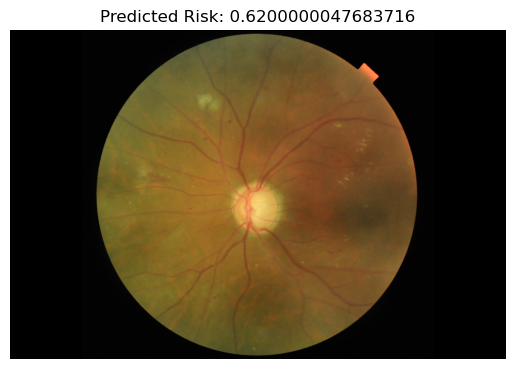

probability is :  {'Disease_Risk': 0.62, 'DR': 0.09, 'ARMD': 0.0, 'MH': 0.02, 'DN': 0.05, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.04, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


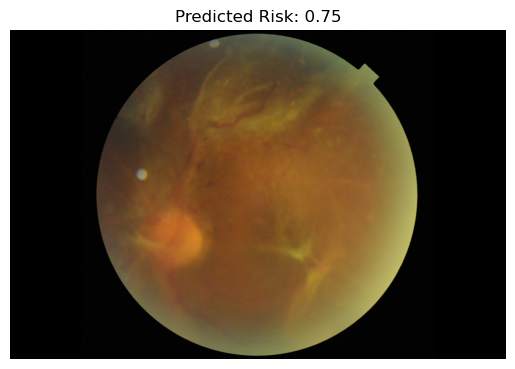

probability is :  {'Disease_Risk': 0.75, 'DR': 0.08, 'ARMD': 0.01, 'MH': 0.03, 'DN': 0.06, 'MYA': 0.01, 'BRVO': 0.02, 'TSLN': 0.06, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


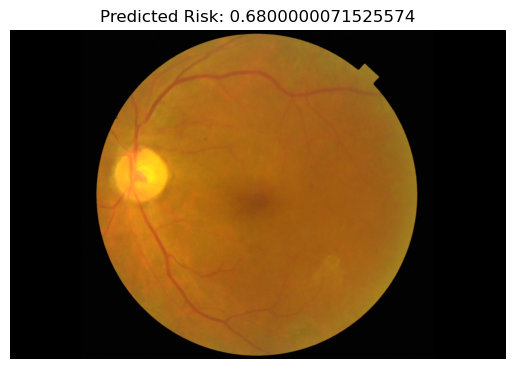

probability is :  {'Disease_Risk': 0.68, 'DR': 0.08, 'ARMD': 0.0, 'MH': 0.02, 'DN': 0.06, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.05, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\15.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


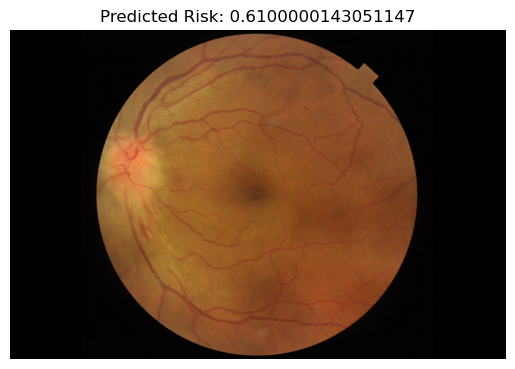

probability is :  {'Disease_Risk': 0.61, 'DR': 0.1, 'ARMD': 0.0, 'MH': 0.02, 'DN': 0.05, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.04, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\16.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


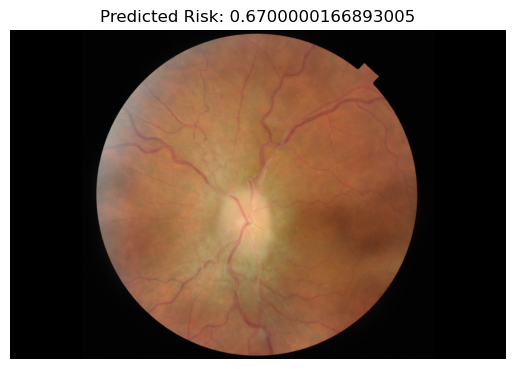

probability is :  {'Disease_Risk': 0.67, 'DR': 0.09, 'ARMD': 0.0, 'MH': 0.02, 'DN': 0.06, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.04, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\17.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


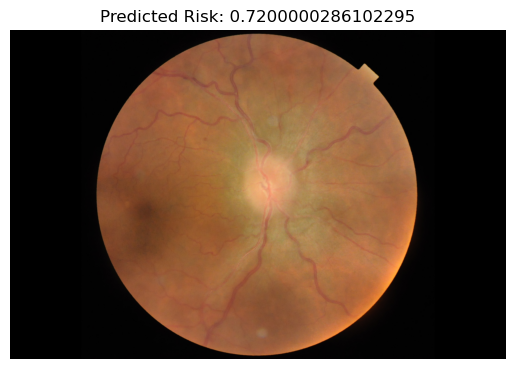

probability is :  {'Disease_Risk': 0.72, 'DR': 0.07, 'ARMD': 0.0, 'MH': 0.03, 'DN': 0.05, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.05, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\18.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


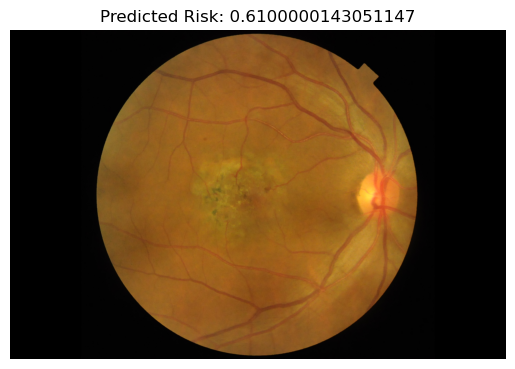

probability is :  {'Disease_Risk': 0.61, 'DR': 0.1, 'ARMD': 0.0, 'MH': 0.02, 'DN': 0.05, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.04, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\19.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


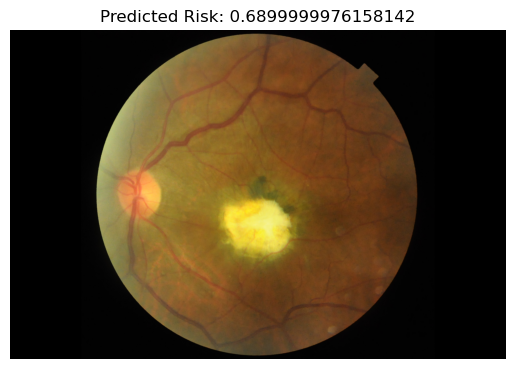

probability is :  {'Disease_Risk': 0.69, 'DR': 0.1, 'ARMD': 0.01, 'MH': 0.03, 'DN': 0.06, 'MYA': 0.01, 'BRVO': 0.02, 'TSLN': 0.05, 'ERM': 0.0, 'LS': 0.01}
E:\Project\Material\Evaluation_Set\Evaluation_Set\Validation\20.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


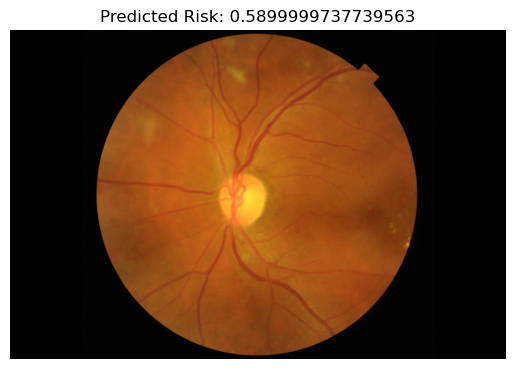

probability is :  {'Disease_Risk': 0.59, 'DR': 0.1, 'ARMD': 0.0, 'MH': 0.02, 'DN': 0.05, 'MYA': 0.01, 'BRVO': 0.01, 'TSLN': 0.04, 'ERM': 0.0, 'LS': 0.01}


In [68]:
# image_path=filedialog.askopenfilename(title="Select image")
for i in range(11,20):
    image_path=(f"E:\\Project\\Material\\Evaluation_Set\\Evaluation_Set\\Validation\\{i+1}.png")
    print(image_path)
    if image_path:
        predic=predict_image(image_path)
        print("probability is : ",predic)

In [71]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Step 1: Create a synthetic dataset (replace this with your actual dataset)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
y = to_categorical(y)  

In [74]:
x.shape

(None, 128)

In [75]:
y.shape

(1000, 2)